In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#import uproot
import pandas as pd
import statistics as st
import os
from numba import njit
import time
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
from loguru import logger
from datetime import datetime
import h5py
import gzip

# warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
# warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
# warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

############## real running ##############

# for arg in sys.argv:
#     run_num=str(arg).zfill(5)
#     # print(run_num)

# chan_enab = int(sys.argv[-1])
# run_start=str(sys.argv[1]).zfill(5)
# run_end=str(sys.argv[2]).zfill(5)
# run_num=str(sys.argv[3]).zfill(5)

# os.chdir('F:/LANL/')
# datadir = 'D:/LANSCE_FP12_2023/data/' ## add directory of hard drive
# uniquefolder = "runs" + str(run_start) + "-" + str(run_end) +"/"
# SFNormFile = 'SF_Norm_files/'+uniquefolder+run_num
# statefileloc = 'F:\LANL\SF_Norm_files\TR_R_expected_avgs_stds_afterclip.csv'
# processedONOFFfolder = '/processed_data/'+uniquefolder+'ONOFF_D/'
# processedasymfolder = '/processed_data/'+uniquefolder+'asym_D/'
# processedasymfolder_bg = '/processed_data/'+uniquefolder+'asym_bg_D/'
# ONOFFSavename = os.getcwd()+processedONOFFfolder+run_num+'_ONOFF_D'
# AsymSavename = os.getcwd()+processedasymfolder+run_num+'_asym_D'
# AsymSavename_bg = os.getcwd()+processedasymfolder_bg+run_num+'_asym_bg_D'
# logger.add("F:/LANL/processed_data/" + uniquefolder + '0_ErrorLog_'+run_start+'_'+run_end+'_D.txt', delay = False)

# if not os.path.exists(os.getcwd()+processedONOFFfolder) or not os.path.exists(os.getcwd()+processedasymfolder) or not os.path.exists(os.getcwd()+processedasymfolder_bg):
#     # Create the directory
#     os.makedirs(os.getcwd()+processedONOFFfolder)
#     os.makedirs(os.getcwd()+processedasymfolder)
#     os.makedirs(os.getcwd()+processedasymfolder_bg)
#     print("Directory created successfully")
# else:
#     pass

############## test running ##############

run_num = '07862'
os.chdir('F:/LANL/')
datadir = 'sample_data/'
runs_folder = 'runs07862-08069/'
uniquefolder = 'debug_sample/'+runs_folder
# uniquefolder = 'La_sample/'
SFNormFile = 'SF_Norm_files/'+'runs07862-08069/'+run_num
# SFNormFile = 'SF_Norm_files/'+runs_folder+run_num
# AsymSavename = '****testing testing testing'
ONOFFSavename = 'F:/LANL/testing_ONOFF'
AsymSavename = 'F:/LANL/testing_asyms'

##########################################

# cannot handle all 24 detectors at once, memory issue... can look into np.empty and deleting variables if needed ##
# chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]) ## all

## added 3He and La Puck below 03.25.25
chan_enab = np.array([0,1,2,3,4,5,6,7,8,9,10,11,24]) ## downstream
# chan_enab = np.array([12,13,14,15,16,17,18,19,20,21,22,23,24]) ## upstream
chan_enab_He = np.array([25]) ## downstream


print('processing data: ' + uniquefolder + '/run' + run_num)

# print(os.getcwd() + folder)

start = time.time()
fullstart = time.time()

read_data = []
fileLength = []

def open_file():
    for el in chan_enab:
        # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
        f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
        read_data.append(np.fromfile(file=f, dtype=np.uint16))
        f.close()
        fileLength.append(len(read_data[-1]))
    return read_data, fileLength

open_file()

fileLength = np.asarray(fileLength)
read_data = np.asarray(read_data) ## in detector's case, all are the same size samples, so can do read_data as np array

########### New 3He check ###################

read_data_He = []
fileLength_He = []

for el in chan_enab_He:
    # f = open(datadir + folder + 'run' + run_num + "_ch" + str(el) + ".bin", 'rb')
    f = open(datadir+uniquefolder + 'run' + str(run_num) + "_ch" +str(el) + ".bin", 'rb')
    read_data_He.append(np.fromfile(file=f, dtype=np.uint16))
    f.close()
    fileLength_He.append(len(read_data[-1]))
# return read_data_He, fileLength_He

fileLength_He = np.asarray(fileLength_He)
read_data_He = np.asarray(read_data_He)

##########################################

if chan_enab[-1] != 24:
    emessage = ('last channel is not 6Li detector')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

end = time.time()

# print('file open time: ' + str(end-start))            
print('saving processed data to ' + AsymSavename)
print("Channel is " + str(chan_enab))

processing data: debug_sample/runs07862-08069//run07862
saving processed data to F:/LANL/testing_asyms
Channel is [ 0  1  2  3  4  5  6  7  8  9 10 11 24]


In [2]:
# Store the big header for each channel in arrays

BoardID = []
recordLength = []
numSamples = []
eventCounter = []
decFactor = []
chanDec = []
postTrig = []
groupStart = []
groupEnd = []
timestamp= []
sizeFirstEvent = []
TTT = []

targetDict = {0: "La", 1: "Tb2O3", 2: "Yb2O3", 3: "Sm2O3", 4: "Er2O3", 5: "Ho2O3", 6: "other"}
foilDict = {0: "TBD", 1: "TBD", 2: "TBD", 3: "TBD", 4: "TBD", 5: "TBD", 6: "other"}

target=(read_data[0][5]&0x00F0)>>4
foil=read_data[0][5]&0x000F
targetFlag = read_data[0][5]>>8&1
foilFlag = read_data[0][5]>>9&1
spinFiltFlag = read_data[0][5]>>10&1
spinFlipFlag = read_data[0][5]>>11&1
shutterFlag = read_data[0][5]>>12&1
facilityTrigFlag = read_data[0][5]>>13&1

if targetFlag:
    target=targetDict[(read_data[0][5]&0x00F0)>>4]
else:
    target = "empty"
if foilFlag:
    foil=foilDict[read_data[0][5]&0x000F]
else:
    foil = "empty"
for i in range(0,len(chan_enab)):
    BoardID.append(read_data[i][9]>>8)
    recordLength.append(((read_data[i][9]&0x00FF)<<16)+read_data[i][8])
    numSamples.append(((read_data[i][11]&0x00FF)<<16)+read_data[i][10])
    eventCounter.append(read_data[i][6]+(read_data[i][7]<<16))
    BoardID.append(read_data[i][9]>>8)  
    decFactor.append(read_data[i][11]>>8)
    chanDec.append(read_data[i][13]>>8)
    postTrig.append(read_data[i][15]>>8)
    groupStart.append(((read_data[i][13]&0x00FF)<<16)+read_data[i][12])
    groupEnd.append(((read_data[i][15]&0x00FF)<<16)+read_data[i][14])
    
    timestamp.append(read_data[i][16]+(read_data[i][17]<<16)+(read_data[i][18]<<32)+(read_data[i][19]<<40))  
    sizeFirstEvent.append(read_data[i][0]+(read_data[i][1]<<16))
    TTT.append(read_data[i][2]+(read_data[i][3]<<16)+(read_data[i][4]<<32))
    
#     print("For channel " + str(chan_enab[i]) + ", BoardID is " + str(BoardID[i])
#           + "; record length is " + str(recordLength[i]) + "; num Samples is " 
#           + str(numSamples[i]) + "; event counter is " + str(eventCounter[i]) + "; dec factor is " + str(decFactor[i]) + "; chan dec is " 
#           + str(chanDec[i]) + "; postTrig is " + str(postTrig[i]) + "; group start is " + str(groupStart[i]) + "; group end is " + str(groupEnd[i])
#           + "; epoch time is " + str(timestamp[i]) +  "; first event size is " + str(sizeFirstEvent[i]) + "; and ETTT is " + str(TTT[i]) + "\n")

BoardID = np.asarray(BoardID) 
recordLength = np.asarray(recordLength)
numSamples = np.asarray(numSamples)
eventCounter = np.asarray(eventCounter)
decFactor = np.asarray(decFactor)
chanDec = np.asarray(chanDec)
postTrig = np.asarray(postTrig)
groupStart = np.asarray(groupStart)
groupEnd = np.asarray(groupEnd)
timestamp = np.asarray(timestamp)
sizeFirstEvent = np.asarray(sizeFirstEvent)
TTT = np.asarray(TTT)

print("Target is " + target)
# print("Foil is " + foil)
# print("Shutter is open: " + str(bool(shutterFlag)))
# print("Facility t0 is on: " + str(bool(facilityTrigFlag)))
# print("Spin flipper is on: " + str(bool(spinFlipFlag)))
# print("Spin filter is on: " + str(bool(spinFiltFlag)))
# print("Target is present: " + str(bool(targetFlag)))
# print("Foil is present: " + str(bool(foilFlag)))

Target is empty


In [3]:
# Determine the time axis for each channel

preTime = []
startTime = []
endTime = []
resolution = []
xs = [] 

for i in range(0,len(chan_enab)):
    preTime.append((100-postTrig[i])*recordLength[i]/100)
    startTime.append((-1*preTime[i]*16*decFactor[i] + groupStart[i]*16*decFactor[i]))
    endTime.append((-1*preTime[i]*16*decFactor[i] + groupEnd[i]*16*decFactor[i]))
    resolution.append(16*chanDec[i]*decFactor[i])
#     print("Pretime for channel", chan_enab[i],"is " + str(preTime[i]) + "; start time is " + str(startTime[i]) + "; end time is " + str(endTime[i]) 
#           + "; resolution is " + str(resolution[i]) + "ns")
    xs.append(np.arange(startTime[i],(numSamples[i])*resolution[i]+startTime[i], resolution[i]))

np.asarray(preTime)
np.asarray(startTime)
np.asarray(endTime)
np.asarray(resolution)

xs = np.asarray(xs) ## can convert xs to np array here because all detectors same numsamples

In [4]:
start=time.time()

@njit
def dataread(data, channels, fileLen, numSamps):
    numRuns = int((fileLen[0]-20-numSamps[0])/(numSamps[0]+6)+1)
    ys_arr = np.zeros((len(channels), numRuns,numSamps[0]), dtype=np.uint16)
    ETTT_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    eventcount_arr = np.zeros((len(channels), numRuns), dtype=np.intc)
    for i in range(0,len(channels)):
        eventCount = 0
        byteCounter = 0
            #byte counter is really 2bytecounter, lol
        while byteCounter < fileLen[i]:
            if byteCounter == 0:
                ETTT_arr[i]=TTT[i]
                #ETTT_arr[i].append(TTT[i])
                eventcount_arr[i]=(eventCounter[i])
                byteCounter = 20
            else:
                ETTT_arr[i]=(data[i][byteCounter]+(data[i][byteCounter+1]<<16)+(data[i][byteCounter+2]<<32))
                eventcount_arr[i]=(data[i][byteCounter+4]+(data[i][byteCounter+5]<<16))
                byteCounter += 6
            for j in range(0, numSamps[i]):
                #if j == 0:
                    #ys_arr[i].append([])
                #print(byteCounter)
                ys_arr[i][eventCount][j]=data[i][byteCounter]
                byteCounter += 1
            eventCount += 1
    return ys_arr, ETTT_arr, eventcount_arr

start=time.time()
ys_arrHe, ETTT_arrHe, eventcount_arrHe  = dataread(read_data, [25], fileLength, numSamples) ##hardcoded channel 25 for He
ys_arr, ETTT_arr, eventcount_arr  = dataread(read_data, chan_enab, fileLength, numSamples) ##hardcoded channels for coils

end = time.time()
print('dataread from binary time: ' + str(end-start))

C:\Users\gabeo\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'channels' of function 'dataread'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\gabeo\AppData\Local\Temp\ipykernel_23056\2559654803.py", line 4:
@njit
def dataread(data, channels, fileLen, numSamps):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


dataread from binary time: 2.44767427444458


In [5]:
timeDif=[]
for i in range(0,len(chan_enab)):
    timeDif.append([])
    for j in range(len(ETTT_arr[i])-1):
        timeDif[i].append((ETTT_arr[i][j+1]-ETTT_arr[i][j])*8)
#     print("Min time difference for channel", chan_enab[i], "is", min(timeDif[i]), "ns")
#     print("Max time difference for channel", chan_enab[i], "is", max(timeDif[i]), "ns \n")
#print(timeDif)

In [6]:
## Not loading SF info for polarization

# Load in SF and He normalization information ##
# SFNormFile2 = 'F:/LANL/SF_Norm_files/runs12034-12363/12036.h5' ## change sf norm file here or use default

try:
    df_SF = pd.read_hdf(SFNormFile + '.h5', key='df_0')
#     df_SF = pd.read_hdf(SFNormFile2, key='df_0')
    df_HE = pd.read_hdf(SFNormFile + '.h5', key='df_1')
#     df_HE = pd.read_hdf(SFNormFile2, key='df_1')
except Exception as e:
    logger.error('run '+run_num + ' failed during SFNormFile load')
    logger.exception(e)

# SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

NormFactor = 1000000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
HeNorms= (He_Norm_arr[1])/NormFactor

# print(SF_Sort_arr)
# print(He_Norm_arr[1]/NormFactor)

In [7]:
# basesub and plotting ##
start = time.time()

baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])  ##70% before the trigger
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
legend =  ['NaI', 'R']

s = 20 ## pulse to look at
t=s+1

#  dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
            plt.legend()
            
# plotter(ys_arr[9:], xs[9:], baseR, numSamples) ##plot coils

@njit ## jit is faster for large # channels, slower for small # channels
def basesub(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
    return tempys_basesub

@njit ## jit is faster for large # channels, slower for small # channels
def basesub_norm(ys, baseRight, numpoints): 
    tempys_basesub = np.zeros((numRuns,numpoints[0]), dtype=np.float64)
    for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
        tempys_basesub[pulse]=np.subtract(ys[pulse], np.mean(ys[pulse][baseL:baseRight]))
        tempys_basesub[pulse]=tempys_basesub[pulse]/HeNorms[pulse] 
    return tempys_basesub

ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
# ys_basesub_norm = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)

for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
    ys_basesub[i] = basesub(ys_arr[i], baseR, numSamples)
# for i in range(len(ys_basesub)): ## feeding y arrays into function 1 channel at  a time is faster than all at once
#     ys_basesub[i] = basesub_norm(ys_arr[i], baseR, numSamples)

ys_basesub[-1] = ys_basesub[-1]*-1 ## invert 6Li to positive signal. Comment out if not using
# ys_basesub_norm[-1] = ys_basesub_norm[-1]*-1 ## invert 6Li to positive signal. Comment out if not using

end = time.time()
print('plotting and/or base subtraction time: ' + str(end-start))            

plotting and/or base subtraction time: 4.204049825668335


In [31]:
# %matplotlib qt
# plt.plot(ys_arr[0][0])
# plt.plot(ys_arr[0][0])
for i in range(0,20):
    plt.plot(ys_basesub[4][i], label = '6Li')
plt.legend()
plt.show()
for i in range(0,20):
    print(ys_arr[-1][i][1996:2004])

[591  27   0   0   0   0   0   0]
[592 405   0   0   0   0   0   0]
[592 592 185   0   0   0   0   0]
[388   0   0   0   0   0   0   0]
[592 178   0   0   0   0   0   0]
[550   0   0   0   0   0   0   0]
[443   0   0   0   0   0   0   0]
[348   0   0   0   0   0   0   0]
[591  69   0   0   0   0   0   0]
[554   0   0   0   0   0   0   0]
[592 276   0   0   0   0   0   0]
[592 591   0   0   0   0   0   0]
[592 496   0   0   0   0   0   0]
[592 592 217   0   0   0   0   0]
[592 592 530   0   0   0   0   0]
[250   0   0   0   0   0   0   0]
[146   0   0   0   0   0   0   0]
[461   0   0   0   0   0   0   0]
[365   0   0   0   0   0   0   0]
[591  85   0   0   0   0   0   0]


In [32]:
# use 6Li t0 for all instead of for themselves individually ##

start = time.time()

NaIthresh=2000
Li6thresh=1000 
# Li6thresh=400  ## had to lower this for no-target
threshold_array = (np.full(len(ys_basesub), NaIthresh))
threshold_array[-1] = Li6thresh

# njit ## numba does not support reversed, but this could be changed if it's slow
def find_offset(ys, thresharr):
    xCrosses = np.zeros((len(ys), numRuns)) #outer array is crossing arrays for given channel, inner array is crossing for each event
    offset = np.zeros((len(ys), numRuns), dtype=np.int32) ##offset in bins for each channel, each pulse
    modeCrosses = np.zeros((len(ys)), dtype=np.float64)
    for i in reversed(range(len(ys))):
        #xValues.append([])
        for p in range(len(ys[i])):
            xing = np.argmax(ys[i][p] > thresharr[i])
            #print(xing)
            xCrosses[i][p] = xing
        modeCrosses[i] = (st.mode(xCrosses[i])) #find the most typical crossing value for each channel
        for p in range(len(xCrosses[i])):
            offset[i][p] = (modeCrosses[-1] - xCrosses[i][p]) ## make sure this is the correct sign!!! 
    if (np.all(xCrosses[-1])) == False:
        emessage = ('ERROR: 6Li threshold was not reached for at least one pulse')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    return offset, xCrosses, modeCrosses
                           
offset, xCrosses, modeCrosses = find_offset(ys_basesub, threshold_array)

end = time.time()
print('finding offset time: ' + str(end-start))  

finding offset time: 0.6061263084411621


In [33]:
# extend all arrays by a value, check that the max number of offset on 6Li is less than that value ##
start = time.time()

extendedRange = 3 ## must be a positive value which to extend ys_arr
if abs(max(offset[-1], key = abs)) > extendedRange: ## if the max offset of 6Li is >extendedRange, something is wrong
    emessage = ('ERROR: largest offset greater than extended range')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

try:
    ys_ext = np.zeros((len(ys_basesub), len(ys_basesub[0]), len(ys_basesub[0][0])+extendedRange*2), dtype=np.float64)
    ys_cut = np.zeros((len(ys_basesub), len(ys_basesub[0]), (len(ys_ext[0][0])-((extendedRange*2)+1)*2)))
    xs_cut = np.zeros((len(ys_cut), len(ys_cut[0][0])))
except Exception as e:
    logger.error('run '+run_num + ' failed during ys_cut array creation')
    logger.exception(e)

# cant use jit because np.pad is not supported ##
def align_cut(ys, xs_arr, extendedr):
    tempys_ext = np.zeros((len(ys), len(ys[0])+extendedr*2), dtype=np.float64)
    tempys_cut = np.zeros((len(ys), (len(tempys_ext[0])-((extendedr*2)+1)*2)))
    tempxs_cut = np.zeros(len(tempys_cut[0]))
    for p in range(len(ys)):
        tempys_ext[p] = np.pad(ys[p], extendedr, 'constant', constant_values=(0))
        tempys_ext[p] = np.roll(tempys_ext[p],offset[-1][p]) ## assumes 6Li at -1 position
        tempys_cut[p] = tempys_ext[p][((extendedr*2)+1):-((extendedr*2)+1)].copy() ## cut by 7 (if extRange == 3)
        tempys_cut[p] = tempys_cut[p]/HeNorms[p] ## normalize by 3He integral  ## comment out if using basesub_norm
    x_cut_amt = int((len(ys[0]) - len(tempys_cut[0]))/2)
    tempxs_cut = xs_arr[x_cut_amt:-x_cut_amt].copy()
    return tempys_cut, tempxs_cut

# looping every channel through function is 5x faster ##
try:
    for i in range(len(ys_basesub)):
        ys_cut[i], xs_cut[i] = align_cut(ys_basesub[i], xs[i], extendedRange)
except Exception as e:
    logger.error('run '+run_num + ' failed aligning and cutting')
    logger.exception(e)
    
# checkp = 2053
# print(offset[-1][checkp]) ## checking offset for one example checkpulse
# print('original index for checkpulse: '+str(np.argmax(ys_basesub[0][checkp]> 2000))) ## we can follow the index as it changes with extension/cut
# #print('extended range index for checkpulse: '+str(np.argmax(ys_ext[0][checkp]> 2000)))
# print('cut array index for checkpulse: '+str(np.argmax((ys_cut[0][checkp]*HeNorms[checkp])> 2000)))

del ys_ext ## might help with memory issues
del ys_basesub

end = time.time()
print('aligning and cutting time: ' + str(end-start))            

aligning and cutting time: 9.883031129837036


### add pulses?

In [34]:
start = time.time()
## new pulse add for polarization attempt ##

# ys_basesub = np.zeros((len(ys_arr), numRuns,numSamples[0]), dtype=np.float64)
added_pulses = np.zeros((len(ys_cut), len(ys_cut[0][0])), dtype=np.float64)  ## channels, 8992 data points each

# @njit
def add_pulse_noSF(ys):
    pulses_sum  = np.zeros((len(ys[0])), dtype=np.float64)
    for p in range(0, len(ys)):
        # print('pulse ',p)
        pulses_sum = np.add(pulses_sum,ys[p])
    return pulses_sum

for i in range(len(ys_cut)):
    # print('#################### channel: ' + str(i) + ' ##########################')
    added_pulses[i] = add_pulse_noSF(ys_cut[i])

end = time.time()
print('summing pulses time: ' + str(end-start))  

summing pulses time: 0.3920009136199951


In [46]:
plt.plot(added_pulses[0])
plt.plot(added_pulses[-1])


In [52]:
%matplotlib qt

T_0 = np.genfromtxt("F:/LANL/sample_data/pol_unpol/unpol_09919.csv", delimiter=",")
T_0 = T_0[4:-4]
print(len(T_0))
T_n = added_pulses[-1]*-1
plt.plot(T_0/max(T_0))
plt.plot(T_n/max(T_n))

8992


In [56]:
justLa = T_0/max(T_0)-T_n/max(T_n)
# plt.plot(justLa)
plt.plot(T_0 - justLa)

In [38]:
%matplotlib qt

T_0 = np.genfromtxt("F:/LANL/sample_data/pol_unpol/unpol_09919.csv", delimiter=",")
T_0 = T_0[4:-4]
print(len(T_0))
T_n = added_pulses[-1]*-1

Npol_Nunpol = T_n/T_0

plt.plot(xs_cut[1], Npol_Nunpol) 
    
#plt.xlim(-50000, 900000)
#plt.ylim(3000,4100)
plt.title('3He N_pol/N_unpol ratio') 
plt.xlabel("TOF (ns)")
plt.ylabel("Npol/Nunpol")

#plt.axvline(xs[0][baseL], ls = '--')
#plt.axvline(xs[0][baseR], ls = '--')
#plt.axvline(xs[1][intgrL], ls = '--', c ='g')
#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

#plt.text(1.5e7, 1200, 'test', fontsize=12)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8992


In [39]:
print(len(T_0))
print(len(T_n))
print(len(xs_cut[1]))

8992
8992
8992


In [40]:
T_0 = np.genfromtxt("F:/LANL/sample_data/pol_unpol/unpol_09919.csv", delimiter=",")
T_0 = T_0[4:-4]
T_0 = T_0[2001:]
T_n = added_pulses[-1][2001:]
print(len(T_0**2/T_n**2))
x_E = 3.895662*10**(-6)*(1/(xs_cut[1][2001:]*10**(-9))**2)
print((x_E[380]))
print(xs[1][2400])
print(3.895662*10**(-6)*(1/(512*10**(-9)))**2)
print((512*10**(-9)))


P_E = np.sqrt(np.absolute(1 - (T_0**2/T_n**2)))

# plt.plot(x_E[380:-1], P_E[380:-1])
xs_cut2 = (xs_cut[1][2001:])
plt.plot(xs_cut2[380:-1]*10**-6, P_E[380:-1]) 

    
#plt.xlim(-50000, 900000)
#plt.ylim(3000,4100)
plt.title('3He Polarization P(E)') 
plt.xlabel("E [eV]")
plt.ylabel("P(E)")

#plt.axvline(xs[0][baseL], ls = '--')
#plt.axvline(xs[0][baseR], ls = '--')
#plt.axvline(xs[1][intgrL], ls = '--', c ='g')
#plt.axvline(xs[1][intgrR], ls = '--', c ='g')
#plt.axvline(xs[2][HeintgrL], ls = '--', c ='r')
#plt.axvline(xs[2][HeintgrR], ls = '--', c ='r')

#plt.text(1.5e7, 1200, 'test', fontsize=12)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6991
100.2581965201499
204800.0
14860771.179199215
5.12e-07


In [10]:
print(df_SF[0:10])

   nicknames transition transition_locations  sumsTR_R      TR_R_avgs  \
0          7   100->111                   36  -27026.0  -27027.651603   
1          0   111->101                   81  118504.0  118485.342566   
2          1   101->100                  126 -116447.0 -116448.357143   
3          2   100->110                  171  340066.0  339956.354227   
4          3   110->101                  216   65802.0   65772.785714   
5          4   101->110                  261   27089.0   27012.142857   
6          5   110->111                  306 -176666.0 -176773.571429   
7          6   111->100                  351  -65840.0  -65863.692308   
8          7   100->111                  396  -27064.0  -27027.651603   
9          0   111->101                  441  118471.0  118485.342566   

    TR_R_stds  
0   40.467677  
1   44.114028  
2    8.268763  
3   93.211060  
4   55.503125  
5   55.156734  
6  108.376799  
7   42.709006  
8   40.467677  
9   44.114028  


## begin SF organization ##

In [12]:
def organize_SF(SFsort_info): ## sometimes pulse 0 has the state switch. In that case, need to account by if clauses below
    counter = 0
    seq = 0
    seq_arr = ([[],[],[]])
    smallerseq = []
    smallerstateis = []
    for i in range(len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))):  ##111 mod 8 = 7, so essentially 111-7 = 104
        counter = counter+1
        if counter < 8:
            if (SF_Sort_arr[1][i]) == 0: ## catches state switches at pulse 0
                smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
                smallerseq.append(SFsort_info[0][i+1])
                seq = seq+1
                continue
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
        elif counter == 8:
            if ((SF_Sort_arr[1][i])+45) >= 5000: ## breaks for state switches at pulse 0
                print(((SF_Sort_arr[1][i])+5))
                seq = seq+1
                seq_arr[0].append(seq)
                seq_arr[1].append(smallerseq)   
                seq_arr[2].append(smallerstateis)
                seq_arr[0] = [x-1 for x in seq_arr[0]] ## reset so sequences are 1-14 instead of 2-15
                break
            seq = seq+1 ## otherwise continue regular sorting
            smallerstateis.append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
            smallerseq.append(SFsort_info[0][i+1])
            seq_arr[0].append(seq)
            seq_arr[1].append(smallerseq)   
            seq_arr[2].append(smallerstateis)
            smallerseq = []
            smallerstateis = []
            counter  = 0
    return seq_arr

def find_leftover(SFsort_info, seq_arr): ## in case we want to use the other 6 states left over
    left = [[seq_arr[0][-1]+1],[],[]]
    counter = 0
    for i in range((len(SFsort_info[1])-(np.mod((len(SFsort_info[1])), 8))), len(SFsort_info[1])-1):
        counter = counter+1
        if counter < 8:
            left[1].append(SFsort_info[0][i+1])
            left[2].append([(SFsort_info[1][i])+5,(SFsort_info[1][i+1])])
    return left

try:
    sequence = organize_SF(SF_Sort_arr)
    if len(sequence[0]) == 14: ## catches state switches at pulse 0, leftovers are at the end of the regular sequence
        leftovers = [[sequence[0][-1]],[sequence[1][-1]],[sequence[2][-1]]]
        for i in range(len(sequence)):
            sequence[i].pop(-1) ## deletes the leftovers sequence for state switches at pulse 0
    else:
        leftovers = find_leftover(SF_Sort_arr, sequence) ## otherwise can use normal function
except Exception as e:
    logger.error('run '+run_num + ' failed during sequencing')
    logger.exception(e)

# print('sequences '+str(sequence[0]))
print(str(len(sequence[0]))+' sequences with sequence order: '+str(sequence[1][0]))
# print(leftovers)

2025-04-01 15:14:09.901 | ERROR    | __main__:<module>:56 - run 12400 failed during sequencing
2025-04-01 15:14:09.905 | ERROR    | __main__:<module>:57 - name 'SF_Sort_arr' is not defined
Traceback (most recent call last):

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
           │         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
           │         └ <code object <module> at 0x000001DFFB3B43A0, file "C:\Users\gabeo\anaconda3\lib\site-packages\ipykernel_launcher.py", line 1>
           └ <function _run_code at 0x000001DFFB5AF040>

  File "C:\Users\gabeo\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
         │     └ {'__name__': '__main__', '__doc__': 'Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel pack...
         └ <code object <module> at 0x0

NameError: name 'sequence' is not defined

In [318]:
print(sequence)
print(type(sequence))

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [[6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5], [6, 7, 0, 1, 2, 3, 4, 5]], [[[33, 73], [78, 118], [123, 163], [168, 208], [213, 253], [258, 298], [303, 343], [348, 388]], [[393, 433], [438, 478], [483, 523], [528, 568], [573, 613], [618, 658], [663, 703], [708, 748]], [[753, 793], [798, 838], [843, 883], [888, 928], [933, 973], [978, 1018], [1023, 1063], [1068, 1108]], [[1113, 1153], [1158, 1198], [1203, 1243], [1248, 1288], [1293, 1333], [1338, 1378], [1383, 1423], [1428, 1468]], [[1473, 1513], [1518, 1558], [1563, 1603], [1608, 1648], [1653, 1693], [1698, 1738], [1743, 1783], [1788, 1828]], [[1833, 1873], [1878, 1918], [1923, 1963], [1968, 2008], [2013, 2053], [2058, 2098], [210

In [323]:
## continue here

print(problems)
print(problems[1])
# print(sequence[2][7])
print(len(sequence[2]))
for prob in range(len(problems)):
    print(problems[prob])
    for seq in range(len(sequence[2])):
        for reg in range(len(sequence[2][seq])):
            stateregs = sequence[2][seq][reg]
    #         print(stateregs[0])
    #         print(sequence[2][seq][reg])
    #     print(len(sequence[2][seq]))
#             print(problems[prob])
            if stateregs[0]<=problems[prob]<=stateregs[1]:
                print('uh oh', str(stateregs), 'seq ', str(seq))
                break

[ 464  808  810 1458 1523 1634 1635 1890 1891 3749 3996 3997 4251 4253]
808
13
464
uh oh [438, 478] seq  1
808
uh oh [798, 838] seq  2
810
uh oh [798, 838] seq  2
1458
uh oh [1428, 1468] seq  3
1523
uh oh [1518, 1558] seq  4
1634
uh oh [1608, 1648] seq  4
1635
uh oh [1608, 1648] seq  4
1890
uh oh [1878, 1918] seq  5
1891
uh oh [1878, 1918] seq  5
3749
uh oh [3723, 3763] seq  10
3996
uh oh [3993, 4033] seq  11
3997
uh oh [3993, 4033] seq  11
4251
uh oh [4218, 4258] seq  11
4253
uh oh [4218, 4258] seq  11


In [321]:
## continue here

print(problems)
print(problems[1])
# print(sequence[2][7])
print(len(sequence[2]))
#     print(problems[prob])
for seq in range(len(sequence[2])):
    for reg in range(len(sequence[2][seq])):
        stateregs = sequence[2][seq][reg]
#         print(stateregs[0])
#         print(sequence[2][seq][reg])
#     print(len(sequence[2][seq]))
#             print(problems[prob])
#     print(stateregs)
    for prob in range(len(problems)):
        if stateregs[0]<=problems[prob]<=stateregs[1]:
            print('uh oh', str(stateregs), 'seq ', str(seq))
            print(problems[prob])
            break

[ 464  808  810 1458 1523 1634 1635 1890 1891 3749 3996 3997 4251 4253]
808
13
uh oh [1428, 1468] seq  3
1458


In [285]:
import copy

In [287]:
# test = [del sequence[0], 7,del sequence[1], 7,del sequence[2], 7]
# print(problems)
# print(sequence[2][7])
test = copy.deepcopy(sequence)
print(test[0])
print(test[2][7])
print(len(test))
print(len(test[1]))
print(len(test[0]))
test = np.delete(test,7,1)
print(test[0])
print(test[2][7])
print(len(test))
print(len(test[1]))
print(len(test[0]))
# test = [np.delete(test[0],7)]
# print(np.delete(test,7,1))
# print(len(test[0]))

# del test[0][7]
# del test[1][7]
# del test[2][7]
# print(len(test))
# print(len(sequence))
# # print(len(test))
# print(len(sequence[1]))
# print(test)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[[2553, 2593], [2598, 2638], [2643, 2683], [2688, 2728], [2733, 2773], [2778, 2818], [2823, 2863], [2868, 2908]]
3
13
13
[1 2 3 4 5 6 7 9 10 11 12 13]
[[2913, 2953], [2958, 2998], [3003, 3043], [3048, 3088], [3093, 3133], [3138, 3178], [3183, 3223], [3228, 3268]]
3
12
12


In [242]:
print(sequence[2][7])
# print(sequence[0], sequence[2])
# print(test[0], test[2])

[[2553, 2593], [2598, 2638], [2643, 2683], [2688, 2728], [2733, 2773], [2778, 2818], [2823, 2863], [2868, 2908]]


In [13]:
#  add up pulses for their respective state, in each 8 step sequence ##
#  turning into a by-channel function 06.13.24 ##

start = time.time()
sequence = np.asarray(sequence, dtype = object)

ON_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF

# @njit
def add_pulse(ys, SFarr):
    temp_ON = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_OFF = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    for seq in range(0, len(SFarr[0])): ## for every sequence
    #         print('seq:' +str(SFarr[0][seq]))
#         print('seq:' +str(seq))
        for state in range(0, len(SFarr[1][0])): ## for every state in the sequence
    #         print("states loop " + str(range(0, len(SFarr[1][0]))[0]) + ' - ' +  str(range(0, len(SFarr[1][0]))[-1]))
            s = SFarr[1][seq][state] ## try this to condense code. Basically, the state currently at
            if s==0 or s==3 or s==5 or s==6: ## these are ON states
#                 print('ON "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_ON[seq] = np.add(temp_ON[seq],ys[p]) ## start with zeros, add to each iteratively
            if s==1 or s==2 or s==4 or s==7: ## these are OFF states
#                 print('OFF "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])):
                    temp_OFF[seq] = np.add(temp_OFF[seq],ys[p])
    return temp_ON, temp_OFF

for i in range(len(ys_cut)):
#     print('#################### channel: ' + str(i) + ' ##########################')
    ON_sums[i], OFF_sums[i] = add_pulse(ys_cut[i], sequence)
    
# for i in range(len(ys_basesub)-12):
#     print('#################### channel: ' + str(i) + ' ##########################')
#     ON_sums[i], OFF_sums[i], ON_minus_sums[i], ON_plus_sums[i] = add_pulse(ys_basesub[i], sequence)

end = time.time()
print('summing pulses into their states time: ' + str(end-start))  

NameError: name 'sequence' is not defined

In [15]:
print(len(ON_sums))
print(len(ON_sums[1]))
print(len(ON_sums[1][1]))
print(len(OFF_sums))
print(len(OFF_sums[1]))
print(len(OFF_sums[1][1]))
# plt.plot(ON_sums[-1][0])

13
13
8992
13
13
8992


### cleaned up fitting

In [16]:
from scipy import odr
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

#### bg fitting

In [17]:
bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]

In [18]:
## change to 2nd order poly in cleaned up version
start = time.time()

def bg_fitsubtract(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
#     seq_bgsub = []
    for seq in range(0, len(ys)): ## number of sequences, usually 13
        fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]
        fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]
        datasplice = np.append(fitdata1, fitdata2)
#         x = np.linspace(0, len(datasplice),len(datasplice))
        y = datasplice
        data = odr.Data(x, y)
        poly_model2 = odr.polynomial(2)  # using third order polynomial model
        odr_obj = odr.ODR(data, poly_model2)
        output = odr_obj.run()  # running ODR fitting
        poly2 = np.poly1d(output.beta[::-1])
        poly_y2 = poly2(x)
        fullpoly_y2 = poly2(fullx)
        bgsubtracted = ys[seq][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
#         seq_bgsub.append(bgsubtracted)
        ys_bgsub.append(bgsubtracted)
#     ys_bgsub.append(seq_bgsub)
    return ys_bgsub

## background subtraction currently only for NaI detectors
num_fittingchs = len(ON_sums)-1  ## removes the Li detector, assumes it is there
ON_bgsub = np.zeros((num_fittingchs,len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction
OFF_bgsub = np.zeros((num_fittingchs,len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

for i in range(0, len(ON_sums)-1):
    if chan_enab[i] == 24:
        emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error(run_num + emessage)
        raise Exception(emessage)
#     print(chan_enab[i])
    ON_bgsub[i]  = bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i])
    OFF_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[i])
    
# for i in range(len(testfunc)):
#     plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, testfunc[i], lw = '1.0', label='3rd Order polynomial background subtracted')

end = time.time()
print('bg_ fitting time: ' + str(end-start))  

bg_ fitting time: 13.960756540298462


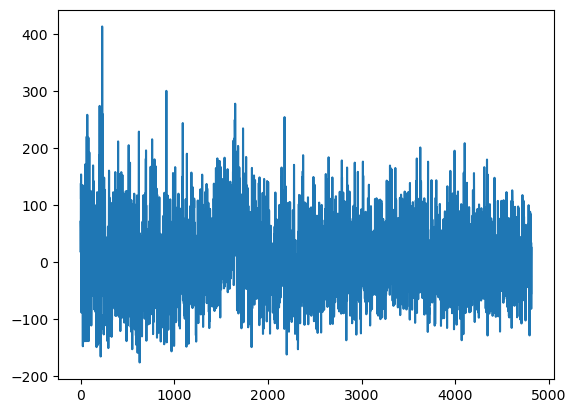

In [19]:
plt.plot(ON_bgsub[0][0])

In [20]:
%matplotlib qt
ch = 1
seq = 0
plt.plot(xs_cut[1]*1e-6, ON_sums[ch][seq], lw = '1.0')
reg_full = ON_sums[ch][seq][bg_reg1[0]:8992]
xs_bg_reg = xs_cut[ch][bg_reg1[0]:bg_reg2[1]]*1e-6  ## new 11.21.24
# left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
# bgsubtracted2 = ON_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2
# bgsubtracted3 = ON_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
# bgsubtracted2OFF = OFF_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2

bgsubtracted2 = ON_bgsub[ch][seq]

# plt.plot(test_polyregx, left, color = 'y')
# plt.plot(test_polyregx2, right, color = 'r')
plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full bg_ subtraction region')

# res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# res_only = np.append(res_only,right)
plt.plot(xs_bg_reg, bgsubtracted2, color = 'r', lw = '1.0', label='2nd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted3, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][0][bg_reg1[0]:bg_reg2[1]], color = 'g', lw = '1.0', label='simple subtraction')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_bgsub[1][0]-ON_bgsub[1][0], color = 'm', lw = '1.0', label='fit subtraction?')

plt.axhline(0, ls='--')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()

In [21]:
print(ON_bgsub[-1])

[[  30.41604415  131.68166886   17.53360467 ... -146.78749339
  -186.8637918   -94.85704659]
 [-122.0030031    42.8910971   111.30101504 ...    6.10219344
   150.7868438    86.12156165]
 [ -18.89787493   89.81747056   18.64327656 ... -109.14017166
   -29.90670034  -65.78030222]
 ...
 [ 418.7636542   131.89452534 -198.63553538 ... -126.85054427
    16.17900581  -18.98797325]
 [  69.76274621  131.57485578  120.61444849 ...  177.82934001
  -113.13022574  -28.7810197 ]
 [ 141.76371352  275.27522321   38.67418833 ... -159.8721108
    -8.74978203  -67.0955684 ]]


#### now voigt

In [22]:
def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

In [23]:
# res_region_beg = 5450
# res_region_end = 6250
res_region_beg = bg_region1_end  ##currently res region is not selectable... inside of background region
res_region_end = bg_region2_beg
res_reg = [res_region_beg,res_region_end]
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
# ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]] ## generalize

In [24]:
print(len(xdata))
# print(len(ydata))
print(len(ON_bgsub))
print(len(ON_bgsub[0]))
print(len(ON_bgsub[0][0]))
print(res_reg[1]-res_reg[0])

800
12
13
4812
800


In [25]:
# resonance region is assumed to be in between 2 background regions. Could maybe change this. 11.22.24

start = time.time()
 
def voigt_fitting(bef_res_reg, aft_res_reg,xs,ys):
    fit_curves = []
#     amplitudes = []
    parameters = []
#     parameters = []
#     parameters_err = []
    for seq in range(0, len(ys)): ## number of sequences, usually 13
#         params = []
#         params_err = []
        ydata = ys[seq][bef_res_reg[1]-bef_res_reg[0]:aft_res_reg[0]-bef_res_reg[0]] 
        popt, pcov = curve_fit(voigt2, xs, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
        fitted_curve = voigt2(xs, popt[0],popt[1],popt[2],popt[3],) ## sigma, gamma, xshift (res. center), amp. related thing
#         amp = max(fitted_curve)
        fit_curves.append(fitted_curve)
#         amplitudes.append(amp)
        fit_params = popt
        fit_errs = np.diagonal(pcov)
        parameters.append([fit_params,fit_errs])
#         parameters_err.append(fit_errs)
#     return fit_curves, amplitudes, parameters, parameters_err
#     return fit_curves, parameters, parameters_err
    return fit_curves, parameters


# testcure, testparam = voigt_fitting(bg_reg1,bg_reg2, xdata,ON_bgsub[1]) ## can take this out later

res_size = res_reg[1]-res_reg[0] 
ON_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## channels, sequences, range of V_ subtraction
OFF_vfit = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),res_size), dtype = np.float64) ## channels, sequences, range of V_ subtraction
print(len(ON_vfit), len(ON_vfit[0]),len(ON_vfit[0][0]))
ON_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64) ## channels, sequences,[params, param_errs], [sigma, gamma, shift, amp thing]
OFF_vfit_params = np.zeros((len(ON_bgsub),len(ON_bgsub[0]),2,4), dtype = np.float64)
print(len(ON_vfit), len(ON_vfit[0]),len(ON_vfit[0][0]))

for i in range(0, len(ON_sums)-1): 
    if chan_enab[i] == 24:
        emessage = ('bg_ fit does not work for 6Li yet')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    try:
        print(chan_enab[i])
        ON_vfit[i], ON_vfit_params[i]  = voigt_fitting(bg_reg1,bg_reg2,xdata, ON_bgsub[i])
        OFF_vfit[i], OFF_vfit_params[i] = voigt_fitting(bg_reg1,bg_reg2,xdata, OFF_bgsub[i])
    except Exception as e:
        logger.error('run '+run_num + ' failed during Voigt fitting')
        logger.exception(e)
    
print(len(ON_vfit), len(ON_vfit[0]), len(ON_vfit[0][0]))
print(len(ON_vfit_params), len(ON_vfit_params[0]), len(ON_vfit_params[0][0]), len(ON_vfit_params[0][0][0]))
end = time.time()
print('bg_ fitting time: ' + str(end-start)) 

12 13 800
12 13 800
0
1
2
3
4
5
6
7
8
9
10
11
12 13 800
12 13 2 4
bg_ fitting time: 11.510457754135132


In [26]:
%matplotlib qt
ch = 6
seq = 5
plt.plot(xs_cut[1]*1e-6, ON_sums[ch][seq], lw = '1.0')
reg_full = OFF_sums[ch][seq][bg_reg1[0]:8992]
xs_bg_reg = xs_cut[ch][bg_reg1[0]:bg_reg2[1]]*1e-6  ## new 11.21.24
# left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
# bgsubtracted2 = ON_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2
# bgsubtracted3 = ON_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
# bgsubtracted2OFF = OFF_sums[ch][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2

# bgsubtracted2 = ON_bgsub[ch][seq]
bgsubtracted2 = OFF_bgsub[ch][seq]

# plt.plot(test_polyregx, left, color = 'y')
# plt.plot(test_polyregx2, right, color = 'r')
plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full bg_ subtraction region')

# res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# res_only = np.append(res_only,right)
plt.plot(xs_bg_reg, bgsubtracted2, color = 'r', lw = '1.0', label='2nd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted3, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][0][bg_reg1[0]:bg_reg2[1]], color = 'g', lw = '1.0', label='simple subtraction')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_bgsub[1][0]-ON_bgsub[1][0], color = 'm', lw = '1.0', label='fit subtraction?')

plt.axhline(0, ls='--')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()

In [139]:
ch = 10
seq = 3
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs_cut[ch][res_reg[0]:res_reg[1]]*1e-6
# ydata = ON_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = OFF_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]


def voigt2(x, sig, gam, xshift, amp):
#     sig = 0.055
#     xshift = 1.96767
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

popt, pcov = curve_fit(voigt2, xdata, ydata, bounds = ([0,0,0,-np.inf], [np.inf,np.inf,np.inf, np.inf]))
print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0], popt[1], popt[2], popt[3],)

# print(max(fitted_curve))
# print((popt[3])*np.sqrt(2*np.pi))
# print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
# print((popt[3])/(popt[0]))
# print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

[ 0.01860775  0.03096939  1.97015874 16.13343916]
[[ 1.14582745e-04 -9.62602550e-05  7.36551066e-09 -9.57414661e-03]
 [-9.62602550e-05  9.52180003e-05 -7.61195378e-09  1.10185728e-02]
 [ 7.36551066e-09 -7.61195378e-09  6.41858429e-06 -9.81151556e-07]
 [-9.57414661e-03  1.10185728e-02 -9.81151556e-07  1.92084611e+00]]


In [140]:
print(ydata[10:20])
print(fitted_curve[10:20])

plt.plot(xdata,ydata, ls = 'none', marker = '.')
plt.plot(xdata, fitted_curve)

[ 79.23274267  24.35352391  95.58994256 -32.34376382 -70.43580095
  28.24846706 -45.98816308 141.49192521   8.09565566 -92.51695376]
[4.12180377 4.14338225 4.16513057 4.18705052 4.20914391 4.23141257
 4.25385835 4.27648314 4.29928885 4.3222774 ]


In [141]:
from scipy import stats as st


In [142]:
print(len(ydata))
print(len(fitted_curve))
print(np.sum(ydata))
print(np.sum((np.sum(ydata)/np.sum(fitted_curve))*fitted_curve))

800
800
26412.106388483757
26412.106388483757


In [143]:
st.chisquare(ydata, f_exp=(np.sum(ydata)/np.sum(fitted_curve))*fitted_curve)
print(st.chisquare(ydata, f_exp=(np.sum(ydata)/np.sum(fitted_curve))*fitted_curve, ddof=4))

Power_divergenceResult(statistic=333909.30819295463, pvalue=0.0)


In [39]:
from lmfit.models import VoigtModel
from lmfit import Parameters,minimize, fit_report
params = Parameters()
# # Slope is bounded between min value of 1.0 and max value of 3.0
# params.add('a', min= 0.0, max= 23.0)
# # Intercept is made fixed at 0.0 value
# params.add('b', min= 0.0, max= 1.0)

In [40]:
print(VoigtModel)
from lmfit.models import LorentzianModel


<class 'lmfit.models.VoigtModel'>


In [63]:
## this might work...

from lmfit.models import GaussianModel

ch = 6
seq = 5
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs_cut[ch][res_reg[0]:res_reg[1]]*1e-6
# ydata = ON_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = OFF_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
x = xdata
y = ydata

mod = GaussianModel()

pars = mod.guess(y, x=x)
pars.add('gamma', min == 0)
# pars = Parameters()
# # Slope is bounded between min value of 1.0 and max value of 3.0
# pars.add('amplitude', min= 0)
# # Intercept is made fixed at 0.0 value
# pars.add('center', value = 1.967)
# pars.add('sigma', min= 0)
# # pars.add('gamma', min= 0)
out = mod.fit(y, pars, x=x)
# print(out.best_fit)

print(out.fit_report(min_correl=0.25))
plt.plot(xdata,ydata)
# plt.plot(xdata, out.init_fit, ls = '--')
plt.plot(xdata, out.best_fit, ls = '--')

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 800
    # variables        = 4
    chi-square         = 3565482.53
    reduced chi-square = 4479.24941
    Akaike info crit   = 6729.75858
    Bayesian info crit = 6748.49703
    R-squared          = 0.08782471
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  6.79346154 (init = 251.2307)
    center:     1.96950990 (init = 1.983244)
    sigma:      0.05426106 (init = 0.203008)
    fwhm:       0.12777503 == '2.3548200*sigma'
    height:     49.9474061 == '0.3989423*amplitude/max(1e-15, sigma)'
    gamma:      0.00000000 (init = 0)


In [102]:
print((out.summary()).keys())
print((out.summary())['best_values'])
print((out.summary())['params'][0])
print((out.summary())['params'][1])
print((out.summary())['params'][2])
print((out.summary())['params'][3])
print((out.summary())['params'][4])
print((out.summary())['params'][5])
print((out.summary())['redchi'])
print((out.summary())['calc_covar'])


dict_keys(['model', 'method', 'ndata', 'nvarys', 'nfree', 'chisqr', 'redchi', 'aic', 'bic', 'rsquared', 'nfev', 'max_nfev', 'aborted', 'errorbars', 'success', 'message', 'lmdif_message', 'ier', 'nan_policy', 'scale_covar', 'calc_covar', 'ci_out', 'col_deriv', 'flatchain', 'call_kws', 'var_names', 'user_options', 'kws', 'init_values', 'best_values', 'params'])
{'amplitude': 6.793461536565543, 'center': 1.9695099049118192, 'sigma': 0.054261059429250746}
('amplitude', 6.793461536565543, True, None, -inf, inf, None, None, None, 251.23067397419084, None)
('center', 1.9695099049118192, True, None, -inf, inf, None, None, None, 1.9832440144404329, None)
('sigma', 0.054261059429250746, True, None, 0.0, inf, None, None, None, 0.20300799999999997, None)
('fwhm', 0.12777502796518825, False, '2.3548200*sigma', -inf, inf, None, None, None, 0.47804729855999994, None)
('height', 49.947406093180575, False, '0.3989423*amplitude/max(1e-15, sigma)', -inf, inf, None, None, None, 493.70735589638764, None)
(

In [104]:
print(out.plot())

Figure(640x640)


In [25]:
# def power_fitting_lmfit(params,x,y):
#     a = params['a']
#     b = params['b']
#     y_fit = a* x **b
#     return y_fit-y

xdata = xs_cut[ch][res_reg[0]:res_reg[1]]*1e-6
# ydata = ON_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = OFF_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
x=xdata
y=ydata

VM = VoigtModel()

params = Parameters()
# Slope is bounded between min value of 1.0 and max value of 3.0
params.add('amplitude', min= 0)
# Intercept is made fixed at 0.0 value
params.add('center', value = 1.967)
params.add('sigma', min= 0)
params.add('gamma', min= 0)

print(VM.param_names)
curve = VM.fit(y,x=x, params)
print(curve.fit_report())

plt.plot(curve)
# Calling the minimize function. Args contains the x and y data.
# fitted_params = minimize(VoigtModel, params, args=(xdata,ydata,), method='least_squares')

# # Getting the fitted values
# a = fitted_params.params['amplitude'].value
# b = fitted_params.params['center'].value    

# # Printing the fitted values
# print('The a is ', a)
# print('The b is ', b)

# # Pretty printing all the statistical data
# print(fit_report(fitted_params))

SyntaxError: positional argument follows keyword argument (3908195555.py, line 24)

In [34]:
x = xdata
y = ydata

mod = VoigtModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))
# plt.plot(out)
# plt.plot(xdata,ydata)

[[Model]]
    Model(voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 800
    # variables        = 3
    chi-square         = 3580689.63
    reduced chi-square = 4492.70970
    Akaike info crit   = 6731.16340
    Bayesian info crit = 6745.21723
    R-squared          = 0.08393420
[[Variables]]
    amplitude:  7.41259001 +/- 0.97598954 (13.17%) (init = 376.846)
    center:     1.96642394 +/- 0.00667519 (0.34%) (init = 1.983244)
    sigma:      0.02850368 +/- 0.00488835 (17.15%) (init = 0.1319552)
    gamma:      0.02850368 +/- 0.00488835 (17.15%) == 'sigma'
    fwhm:       0.10265004 +/- 0.01760438 (17.15%) == '1.0692*gamma+sqrt(0.8664*gamma**2+5.545083*sigma**2)'
    height:     54.2763695 +/- 7.11631934 (13.11%) == '(amplitude/(max(1e-15, sigma*sqrt(2*pi))))*real(wofz((1j*gamma)/(max(1e-15, sigma*sqrt(2)))))'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.6545


In [30]:
## manual fitting
ch = 6
seq = 5

from scipy.special import voigt_profile
from scipy.optimize import curve_fit
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]

## checks that the resonance region and bg region do not overlap 11.21.24
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

## manual fitting
# sigma = 60
# gamma = 30
# beg = 5800
# end = 5900
sigma = 0.055
gamma = 0.02
beg = 5800
end = 5900

shift = 1.96767
mult = 20

# xdata = np.arange(-(res_reg[1]-res_reg[0])/2,(res_reg[1]-res_reg[0])/2,1)  ## centered around 0 for initial fitting
xdata = xs_cut[ch][res_reg[0]:res_reg[1]]*1e-6

# ydata = ON_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
ydata = OFF_bgsub[ch][seq][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

for i in range(0,2):
    voigt = voigt_profile(xdata-shift, sigma, gamma)*i
    plt.plot(xdata, voigt, label = str(i))
    

# print(voigt)
# def voigt2(x, sig, gam, xshift, amp):
#     fit = voigt_profile(x-xshift, sig, gam)*amp
#     return fit
plt.plot(xdata,ydata)
plt.legend()


In [48]:
def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs


In [31]:
sig = popt[0]
gam = popt[1]
fg = 2*sig*np.sqrt(2*np.log(2))
fl = 2*sig
fv = 0.5346*-fl + np.sqrt(0.2166*fl**2+fg**2)
print(fv)

## plotting voigt fit ##

# plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

# plt.plot(xdata, voigt, label = 'manual fit')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$")

rebinf = 2
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

# plt.plot(xdata,ydata, label = r'rawdata')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata, rebin {rebinf}')
# plt.axhline(y = 0)
plt.axvline(x = fv/2+popt[2])
plt.axvline(x = popt[2]-fv/2)
plt.axvline(x = popt[2])


plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

NameError: name 'popt' is not defined

In [229]:
print(OFF_vfit_params[0][0][0][0], OFF_vfit_params[0][0][1][0])
print(OFF_vfit_params[0][2][0][0], OFF_vfit_params[0][2][1][0])
print(OFF_vfit_params[0][6][0][0], OFF_vfit_params[0][6][1][0])
np.sqrt(OFF_vfit_params[0][0][1][0]**2+OFF_vfit_params[0][2][1][0]**2+OFF_vfit_params[0][3][1][0]**2)

0.024609129844617873 0.00017002884812790462
0.06625330808248346 0.00012377074670681014
5.617411487151225e-06 384.92257657804896


0.0003041156366356963

In [227]:
ch = 0
testerr = []
manual = 0
for i in range(0,13):
    testerr.append(OFF_vfit_params[ch][i][0][0])
    manual = manual+OFF_vfit_params[ch][i][0][0]**2
manual  = np.sqrt(manual)
testtoterr = np.sqrt(sum([i**2 for i in testerr]))
print(testtoterr)
print(manual)

0.16131414802785976
0.16131414802785976


In [108]:
print(len(ON_vfit))
print(len(ON_vfit[0]))
print(len(ON_vfit[0][0]))
plt.plot(ON_vfit[0][0])

12
13
800


## now calc asym with "amplitude" 

In [61]:
## sum up all pulses, and then calculate asymmetry using "amplitude"

In [162]:
all_ONOFF = np.zeros((len(ON_sums),2, len(ON_sums[0][0])), dtype=np.float64) ## all summed ON[0] and OFF[1] pulses for each channel, not each sequence

def all_onoff(ON_arr, OFF_arr):
    tempallON = np.zeros((len(ON_arr[0])), dtype=np.float64)
    tempallOFF = np.zeros((len(ON_arr[0])), dtype=np.float64)
    for seq in range(0, len(ON_arr)): ## number of sequences
        tempallON = np.add(ON_arr[seq],tempallON)
        tempallOFF = np.add(OFF_arr[seq],tempallOFF)
    return tempallON, tempallOFF

for i in range(len(ON_sums)):
    all_ONOFF[i][0], all_ONOFF[i][1] = all_onoff(ON_sums[i], OFF_sums[i]) ## channel, ON[0] or OFF[1], summed wave
    # print('ch done')

In [194]:
all_Vfitcurve_ON = np.zeros((len(ON_vfit), len(ON_vfit[0][0])), dtype=np.float64) ## all summed ON or OFF pulses for each channel, not each sequence
all_Vfitcurve_OFF = np.zeros((len(ON_vfit), len(ON_vfit[0][0])), dtype=np.float64) ## all summed ON or OFF pulses for each channel, not each sequence

def all_vfits(vfit_arrs):
    tempall_vfits = np.zeros((len(vfit_arrs[0])), dtype=np.float64)
    for seq in range(0, len(vfit_arrs)): ## number of sequences
        tempall_vfits = np.add(vfit_arrs[seq],tempall_vfits)
    return tempall_vfits

for i in range(len(ON_vfit)):
    all_Vfitcurve_ON[i]  = all_vfits(ON_vfit[i]) ## all added vfits for each channel
    all_Vfitcurve_OFF[i] = all_vfits(OFF_vfit[i]) 
    print('ch done', i)

ch done 0
ch done 1
ch done 2
ch done 3
ch done 4
ch done 5
ch done 6
ch done 7
ch done 8
ch done 9
ch done 10
ch done 11


In [226]:
## add and avg all sigma/gamma/xloc for ON and OFF per channel. Should not be dpendent on spin state.
sig_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 sigma +/- error for each channel
gam_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 gamma +/- error for each channel
xloc_ch = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 xlocation +/- error for each channel

def sum_param(ON_params_arr, OFF_params_arr, key):  ## key choose between sigma gamma or xloc
    if key != 'sigma' and key != 'gamma' and key != 'xloc':
        emessage = ('not a valid Voigt fit parameter to sum')
        logger.error('run '+run_num + emessage)
        raise Exception(emessage)
    if key == 'sigma':
        param = 0
    if key == 'gamma':
        param = 1
    if key == 'xloc':
        param = 2
    tempsum = 0
    temperr  = []
    for seq in range(0, len(ON_params_arr)): ## number of sequences
        seqsum = (ON_params_arr[seq][0][param]+OFF_params_arr[seq][0][param])/2  # "normalize" with /2 but not for #sequences
        ## [0] above corresponds to the real values of the paramters, as opposed to their errors
        ON_err = ON_params_arr[seq][1][param]
        OFF_err = OFF_params_arr[seq][1][param]
        ## above [1] is used which corresponds to the error in "parameter"
        ON_deriv  =  1  ## left over from asym error to keep error prop consistent
        OFF_deriv =  1
        ## use err prop to get below
#         seq_err = np.sqrt((ON_deriv**2)*(ON_err**2)+(OFF_deriv**2)*(OFF_err**2))/2
        seq_err = np.sqrt((ON_err**2)+(OFF_err**2))/2
        print(OFF_err)
        print(seq_err)
        temperr.append(seq_err) ## collect all errors for each sequence
        tempsum = np.add(seqsum,tempsum)
#         print(temperr)
    ## add error or each sequence in quad.
    toterr = np.sqrt(sum([i**2 for i in temperr]))  ## use list comprehension for sum of squares
    out = [tempsum,toterr]
    return out

for i in range(len(ON_vfit)):
    sig_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='sigma')
#     gam_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='gamma') 
#     xloc_ch[i] = sum_param(ON_vfit_params[i], OFF_vfit_params[i], key='xloc') 
    print('param sum ch done', i)

0.00017002884812790462
0.0001135951598030077
0.00025731205470882936
0.00028361885563181916
0.00012377074670681014
9.085570877157162e-05
0.00021967547316501093
0.00012700158098452805
0.00022056751254203346
0.00011813791264626777
0.0001619771601159589
0.00024141111882508746
384.92257657804896
192.46128828903377
0.0001060896280399255
9.956967708960438e-05
0.00010152799486667863
0.000167263308088379
411.0293247660196
205.51466238304803
7.203928902979635e-05
0.0002617810852315276
507.6939604381907
475.3993042156525
0.0001850511573131397
9.96480437310956e-05
param sum ch done 0
5.484160802838755e-05
5.4773360574230886e-05
0.00013878732442864904
8.142518363068749e-05
9.101222548701685e-05
5.6173486521069504e-05
0.0001430692621734869
101.97575546172916
0.00011854718970503453
7.445267018974476e-05
7.130703273161321e-05
6.830349360201171e-05
10.281833915360052
5.140916958548324
7.795003092370198e-05
0.001027370844250407
0.0001016695880182322
5.801464223513686e-05
0.00011245457313948276
6.8744194

In [212]:
print(sig_ch)

[[4.96182089e-01 5.52523413e+02]
 [4.51443561e-01 1.02105258e+02]
 [4.89775072e-01 3.60609899e+00]
 [6.98576442e-01 2.80143515e+02]
 [4.72542563e-01 1.75854230e+01]
 [5.31530383e-01 1.50421774e+01]
 [6.68335991e-01 1.08191739e+01]
 [5.76539240e-01 1.72526298e+01]
 [4.98174725e-01 2.17286547e+02]
 [6.58065660e-01 9.01775846e-02]
 [4.53689016e-01 1.29157301e+00]
 [3.94639766e-01 1.89111465e+02]]


In [182]:
## new asym using "amplitude" parameter, with error prop

# asym_pm = np.zeros((len(ONOFF_plus_sums),2, len(ONOFF_plus_sums[0][0][0])), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)
# asym_ch = np.zeros((len(ON_vfit)), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)
asym_ch_err = np.zeros((len(ON_vfit),2), dtype=np.float64) ## 1 Asym for each channel, not for each sequence (can change?)

# def asym3(ON_params_arr, OFF_params_arr):
#     tempasym = 0
#     for seq in range(0, len(ON_params_arr)): ## number of sequences
#         A_plus = ON_params_arr[seq][0][-1] ## just makes things cleaner
#         A_min  = OFF_params_arr[seq][0][-1]
# #         seqasym = ((ON_params_arr[seq][0][-1]-OFF_params_arr[seq][0][-1]) / (ON_params_arr[seq][0][-1]+OFF_params_arr[seq][0][-1]))
#         ## [0] corresponds to the real values of the paramters, as opposed to their errors. [-1] is the "amplitude"
#         seqasym = ((A_plus-A_min) / (A_plus+A_min))
#         ON_err = ON_params_arr[seq][1][-1]
#         OFF_err = OFF_params_arr[seq][1][-1]
#         ## above [1] is used which corresponds to the error in "amplitude"
#         tempasym = np.add(seqasym,tempasym)
#     ## add error or each sequence asym in quad.
#     return tempasym  ## don't normalize asymON_vfit_params this time...
def asym3_err(ON_params_arr, OFF_params_arr):
    tempasym = 0
    temperr  = []
    for seq in range(0, len(ON_params_arr)): ## number of sequences
        A_plus = ON_params_arr[seq][0][-1] ## just makes things cleaner
        A_min  = OFF_params_arr[seq][0][-1]
#         seqasym = ((ON_params_arr[seq][0][-1]-OFF_params_arr[seq][0][-1]) / (ON_params_arr[seq][0][-1]+OFF_params_arr[seq][0][-1]))
        ## [0] corresponds to the real values of the paramters, as opposed to their errors. [-1] is the "amplitude"
        seqasym = ((A_plus-A_min) / (A_plus+A_min))
        ON_err = ON_params_arr[seq][1][-1]
        OFF_err = OFF_params_arr[seq][1][-1]
        ## above [1] is used which corresponds to the error in "amplitude"
        ON_deriv  =  2*A_min/ ((A_plus+A_min)**2)
        OFF_deriv = -2*A_plus/((A_plus+A_min)**2)
        ## use err prop to get below
        seq_err = np.sqrt((ON_deriv**2)*(ON_err**2)+(OFF_deriv**2)*(OFF_err**2))
#         seq_err = (1/(A_plus+A_min**2))*np.sqrt(4*(A_min**2)(ON_err)**2+4*(A_plus**2)(OFF_err)**2) ## alternate form
        temperr.append(seq_err) ## collect all errors for each sequence
        tempasym = np.add(seqasym,tempasym)
#         print(temperr)
    ## add error or each sequence asym in quad.
    toterr = np.sqrt(sum([i**2 for i in temperr]))  ## use list comprehension for sum of squares
    out = [tempasym,toterr]
    return out  ## don't normalize asymON_vfit_params this time...

for i in range(len(ON_vfit)):
#     asym_ch[i] = asym3(ON_vfit_params[i], OFF_vfit_params[i])
    asym_ch_err[i] = asym3_err(ON_vfit_params[i], OFF_vfit_params[i]) ## error is really high...
    print('asym ch done', i)

asym ch done 0
asym ch done 1
asym ch done 2
asym ch done 3
asym ch done 4
asym ch done 5
asym ch done 6
asym ch done 7
asym ch done 8
asym ch done 9
asym ch done 10
asym ch done 11


In [189]:
print(asym_ch_err.shape)
print(sig_ch.shape)
print(gam_ch.shape)
print(xloc_ch.shape)
print(all_Vfitcurve_ON.shape)
print(ON_vfit.shape)
print(ON_vfit_params.shape)

(12, 2)
(12, 2)
(12, 2)
(12, 2)
(12, 800)
(12, 13, 800)
(12, 13, 2, 4)


In [244]:
## plots each vfit and the total vfit per ch. (and for on or off)
%matplotlib qt
ch = 0
xs_bg_reg = xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6  ## new 11.21.24
plt.plot(xs_bg_reg, ON_bgsub[ch][0])

for i in range(0,13):
    plt.plot(xdata, OFF_vfit[ch][i])
    print(OFF_vfit_params[ch][i][0][3],'+/-' ,OFF_vfit_params[ch][i][1][3])
    print(OFF_vfit_params[ch][i][0][0],'+/-' ,OFF_vfit_params[ch][i][1][0])


# plt.plot(xdata, all_Vfitcurve_ON[ch])
# plt.plot(xdata, all_Vfitcurve_OFF[ch])

plt.show()

11.423205170413123 +/- 1.9028276106042556
0.024609129844617873 +/- 0.00017002884812790462
13.936569493307116 +/- 2.2676332417168203
0.018999565893129067 +/- 0.00025731205470882936
9.235846770587578 +/- 1.8682387217068122
0.06625330808248346 +/- 0.00012377074670681014
10.279405232172582 +/- 2.3719964227431873
0.046493349684848376 +/- 0.00021967547316501093
5.1453224504466935 +/- 1.5816678463561387
0.1023112569967145 +/- 0.00022056751254203346
12.685089546838453 +/- 2.123672936374117
0.02478357356835918 +/- 0.0001619771601159589
13.679137479030569 +/- 1.7095377110398913
5.617411487151225e-06 +/- 384.92257657804896
9.51500611163891 +/- 1.6370809902661922
0.025898221054558034 +/- 0.0001060896280399255
6.926362592069404 +/- 1.338846936459491
0.05667636710496673 +/- 0.00010152799486667863
14.278738315001899 +/- 1.7304923463902635
4.182085456493605e-08 +/- 411.0293247660196
7.567925375055115 +/- 1.2892820343000273
0.05074840620676458 +/- 7.203928902979635e-05
11.838921383377928 +/- 1.57752430

## save all on and off values and asymm + paramters. save out.

In [191]:
## old version

start = time.time()
# testch = 0

with h5py.File(ONOFFSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['sequences'] = len(sequence[0])
    hdf5_file.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
    for i in range(0,len(ys_cut)):
#         with h5py.File('test_allONOFFs'+'.h5', 'a') as hdf5_file:
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i], compression="gzip")
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i])
#     a = hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
#     a.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
#     a.attrs['sequences'] = len(sequence[0])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 0.13002467155456543


In [190]:
print(res_reg)

[5450, 6250]


In [199]:
## new version adds vfit curves

start = time.time()
# testch = 0

with h5py.File(ONOFFSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['sequences'] = len(sequence[0])
    for i in range(0,len(ys_cut)): ## change this to length of asymms!
        Ch_grp = hdf5_file.create_group('ch_'+str(np.char.zfill(str(chan_enab[i]), 2)))
        added_pulses_subgrp = Ch_grp.create_group('added_pulses')
        added_vfits_subgrp = Ch_grp.create_group('added_vfits')
        added_pulses_subgrp.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
        added_pulses_subgrp.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i])
        if chan_enab[i] == 24:
            pass
        else:
            added_vfits_subgrp.attrs['resonance_region'] = res_reg
            added_vfits_subgrp.attrs['note'] = 'added all Voigt fits for each ON or OFF state, per ch.'
            added_vfits_subgrp.create_dataset('Vfit_curve_ON',data=all_Vfitcurve_ON[i])
            added_vfits_subgrp.create_dataset('Vfit_curve_OFF',data=all_Vfitcurve_OFF[i])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 0.1019749641418457


In [200]:
## testing create groups
# test_dat_arr = ON_vfit_params[0]

start = time.time()
# testch = 0

with h5py.File(AsymSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
    hdf5_file.create_dataset('xs ', data=xs_cut[0]) ## all xs are the same, even though they are per channel...
    hdf5_file.attrs['sequences'] = len(sequence[0])
    for i in range(0,len(asym_ch_err)): ## change this to length of asymms!
        Ch_grp = hdf5_file.create_group('ch_'+str(np.char.zfill(str(chan_enab[i]), 2)))
        Ch_grp.attrs['quick asym'] = asym_ch_err[i]
        Ch_grp.attrs['avg_xloc']  = xloc_ch[i]
        Ch_grp.attrs['avg_sigma'] = sig_ch[i]
        Ch_grp.attrs['avg_gamma'] = gam_ch[i]
        ON_subgrp = Ch_grp.create_group('ON')
        OFF_subgrp = Ch_grp.create_group('OFF')
        ON_subgrp.attrs['for_each_sequence'] = ['parameter (sigma, gamma, x_loc, "amplitude")', 'and its error']
        OFF_subgrp.attrs['for_each_sequence'] = ['parameter (sigma, gamma, x_loc, "amplitude")', 'and its error']
        ON_subgrp.create_dataset('parameters',data=ON_vfit_params[i])
        OFF_subgrp.create_dataset('parameters',data=OFF_vfit_params[i])
        ON_subgrp.create_dataset('Vfit_curves',data=ON_vfit[i])
        OFF_subgrp.create_dataset('Vfit_curves',data=OFF_vfit[i])
#         with h5py.File('test_allONOFFs'+'.h5', 'a') as hdf5_file:
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i], compression="gzip")
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=all_ONOFF[i])
#     a = hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0])
#     a.attrs['rownames'] = ['ON_Row0', 'OFF_Row1']
#     a.attrs['sequences'] = len(sequence[0])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 0.13481402397155762


In [ ]:
sig_ch[i] = gam_ch[i] 
    xloc_ch[i]

In [ ]:
## testing reaad
with h5py.File(ONOFFSavename+'.h5', 'r') as f:
    print(f.attrs.keys())
    print(f.attrs.get('sequences'))
    print(f.attrs.get('rownames'))
    f.close()
    
# f = h5py.File('test_allONOFFs'+'.h5', 'r')
# # print(f['ch 00'].attrs.get('sequences'))
# f.close()

In [230]:
%matplotlib qt
ch = 2
plt.title(f'Summed Pulses for channel {ch}')
plt.plot(xs_cut[ch]*1e-6, all_ONOFF[ch][0], label='ON states')
# plt.plot(xs_cut[ch], all_ONOFF[ch][1], label='OFF states')
# plt.plot(xs_cut[ch], asym_ch_raw[ch], label='asymmetry')  ## there's no point in looking at asym for one channel. Need more data
# plt.plot(fullx, asym_ch_bg[ch], label='asymmetry')  # division by 0 is a problem...
plt.plot((fullx-2000+8)*(decFactor[1]*16*1e-6), asym_ch_bg[ch], label='asymmetry')  # division by 0 is a problem...

plt.axvline(x = 1.97, label='p-wave peak?')

plt.legend()
plt.show()

NameError: name 'fullx' is not defined

In [21]:
start = time.time()

with h5py.File(AsymSavename+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=all_ONOFF[0], compression="gzip")
    hdf5_file.create_dataset('xs ', data=xs_cut[0])
    hdf5_file.attrs['sequences'] = len(sequence[0])
    for i in range(0,len(ys_cut)):
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=asym_ch[i])
        
# f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
# np.save(file=f, arr=ys_cut)
# f.close()
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 0.061153411865234375


In [ ]:
## testing reaad
with h5py.File(AsymSavename+'.h5', 'r') as f:
    print(f.attrs.keys())
    print(f.attrs.get('sequences'))
    print(f.attrs.get('rownames'))
    f.close()

In [ ]:
# start = time.time()

# np.save(os.getcwd() + '/testnpysave', asym_ch)
# np.save(os.getcwd() + '/processed_data/'+ 'xs_cut', xs_cut)
# # np.save(os.getcwd() + pmSavename, asym_pm)
# # np.save(os.getcwd() + AsymSavename, Asym)
# end = time.time()
# print('saving as npy ' + str(end-start))  

In [ ]:
fullend = time.time()
print('full processing time: ' + str(fullend-fullstart))  
print('finished ' + str(datetime.now())) 
print('\n')

## end of data processing ##

## Exploring discarding pulses because of small or rapidly changing n flux 

(array([ 346,  347, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119,
       1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130,
       1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141,
       1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152,
       1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163,
       1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174,
       1176, 1178, 1181, 1183, 1185, 1186, 1187, 3542, 3543, 3544, 3545,
       3626, 3627, 3628, 3629], dtype=int64),)
5000


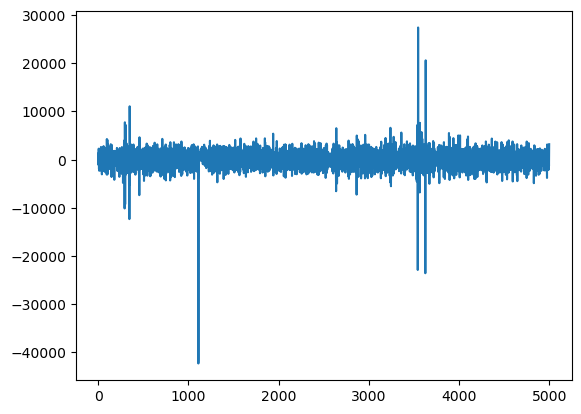

In [9]:
print((np.where(HeNorms<5.3)))
x = HeNorms

dx = x[1]-x[0]
y = x**2 + 1
dydx = np.gradient(y, dx)
print(len(dydx))
plt.plot(dydx)

5000


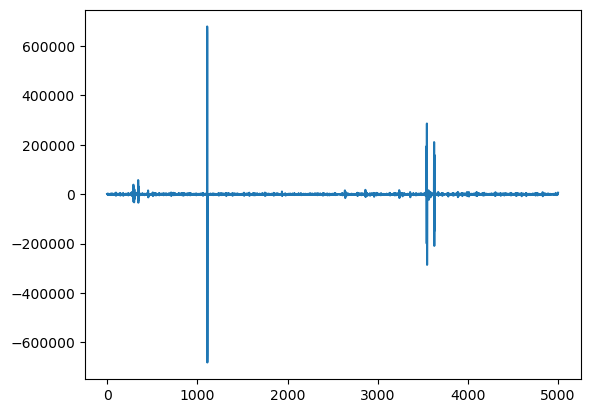

In [10]:
x2 = dydx

dx2 = x2[1]-x2[0]
y2 = x2**2 + 1
dydx2 = np.gradient(y2, dx2)
print(len(dydx2))
plt.plot(dydx2)

In [53]:
## Not loading SF info for polarization
%matplotlib qt

# Load in SF and He normalization information ##
# SFNormFile2 = 'F:/LANL/SF_Norm_files/runs12034-12363/12036.h5' ## change sf norm file here or use default
print(SFNormFile)
temp = 'SF_Norm_files/runs12034-12363/'

for i in range(12034,12200):
#     print(i)
    try:
        df_SF = pd.read_hdf(temp+str(i) + '.h5', key='df_0')
    #     df_SF = pd.read_hdf(SFNormFile2, key='df_0')
        df_HE = pd.read_hdf(temp+str(i) + '.h5', key='df_1')
    #     df_HE = pd.read_hdf(SFNormFile2, key='df_1')
    except Exception as e:
        logger.error('run '+i + ' failed during SFNormFile load')
        logger.exception(e)

    # SF_Sort_arr = df_SF[['nicknames', 'transition_locations']].to_numpy().T
    He_Norm_arr = df_HE[['pulse', 'norms']].to_numpy().T

    NormFactor = 1000000  ## He integrals are huge, this normalizes all of those by a constant value for ease of use
    HeNorms= (He_Norm_arr[1])/NormFactor

    # print(SF_Sort_arr)
    # print(He_Norm_arr[1]/NormFactor)
    if len((np.where(HeNorms<2.0)[0])) > 0:
        print(i)
        print((np.where(HeNorms<1.0)))
    x = HeNorms

    dx = x[1]-x[0]
    y = x**2 + 1
    dydx = np.gradient(y, dx)
#     print(len(dydx))
    if np.mean(np.abs(dydx))>60:
        plt.plot(dydx, label=str(i))
        plt.legend()

    x2 = dydx

    dx2 = x2[1]-x2[0]
    y2 = x2**2 + 1
    dydx2 = np.gradient(y2, dx2)
    if len([*filter(lambda x: x >= 30000, np.abs(dydx2))]) > 0:
#         print(len(dydx2))
        plt.plot(dydx, label = str(i)+ ' baddie!')
plt.axhline(200, ls = '--')

SF_Norm_files/runs12034-12363/12126
12035
(array([1635, 1636, 1646, 1891, 1892, 1901], dtype=int64),)
12039
(array([], dtype=int64),)
12063
(array([], dtype=int64),)
12064
(array([4707], dtype=int64),)
12065
(array([], dtype=int64),)
12067
(array([], dtype=int64),)
12068
(array([3471], dtype=int64),)
12070
(array([], dtype=int64),)
12073
(array([], dtype=int64),)
12079
(array([], dtype=int64),)
12095
(array([], dtype=int64),)
12098
(array([], dtype=int64),)
12106
(array([], dtype=int64),)
12115
(array([4300], dtype=int64),)
12118
(array([], dtype=int64),)
12119
(array([3976], dtype=int64),)
12120
(array([], dtype=int64),)
12122
(array([], dtype=int64),)
12125
(array([], dtype=int64),)
12126
(array([1111, 1112], dtype=int64),)
12127
(array([], dtype=int64),)
12132
(array([], dtype=int64),)
12137
(array([1857, 1858], dtype=int64),)
12139
(array([], dtype=int64),)
12146
(array([], dtype=int64),)
12159
(array([], dtype=int64),)
12161
(array([], dtype=int64),)
12162
(array([2813], dtype=int

In [ ]:
# print(np.where(np.abs(dydx)>90))
problems = np.where(np.abs(dydx)>100)[0]
print(problems)

In [310]:
print(HeNorms)

baseL = 0
baseR = int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])  ##70% before the trigger
numRuns = int((fileLength[0]-20-numSamples[0])/(numSamples[0]+6)+1)
legend =  ['NaI', 'R']

s = 20 ## pulse to look at
t=s+1

#  dont know why this is so slow ##
def plotter(ys, xs, baseR, numpoints):
    tempys_basesub = np.zeros((len(ys), numRuns,numpoints[0]), dtype=float)
    for i in range((len(ys))):
        for pulse in range((len(eventcount_arr[0]))): ## all have 5000 pulses
            tempys_basesub[i][pulse]=np.subtract(ys[i][pulse], np.mean(ys[i][pulse][baseL:baseR]))
        for j in range(s, t): ## plot only interested pulses
            plt.plot(xs[i], tempys_basesub[i][j]) #label=legend[i]) #+str(sums[1][j])) ## sums[j] will not work for more than just TR   
            plt.axvline(xs[0][baseL], ls = '--')
            plt.axvline(xs[0][baseR], ls = '--')
            #plt.axvline(xs[0][int(((preTime[0]-groupStart[0])*0.70)/chanDec[0])], ls = '--', c ='m')
            plt.axvline(xs[0][baseR+5], ls = '--', c ='r') ## BaseR+5 line marks the beginning of the integral, until the end of samples.
#             plt.title('SF state transition' + transitions[p]) 
#             plt.xlabel("time from trigger (ns)")
#             plt.ylabel("ADC")
#             plt.legend()
            
plotter(ys_arr[10:], xs[10:], baseR, numSamples) ##plot coils

[6.75914521 6.7224181  6.82175878 ... 6.42678369 6.47034032 6.41850394]


In [232]:
## old one channel curve/param

xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6  ## just change all xs to ms and one array
ydata = OFF_bgsub[0][6][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]] ## generalize

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

popt, pcov = curve_fit(voigt2, xdata, ydata)
print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
print(ydata[10:20])

[5.61741149e-06 4.33140510e-02 1.96993303e+00 1.36791375e+01]
[[ 3.84922577e+02 -8.10138546e-02  3.30527249e-03 -8.98536446e+00]
 [-8.10138546e-02  4.72178576e-05 -7.01391053e-07  6.70753380e-03]
 [ 3.30527249e-03 -7.01391053e-07  1.46383296e-05 -7.83805934e-05]
 [-8.98536446e+00  6.70753380e-03 -7.83805934e-05  1.70953771e+00]]
[ 34.41607826  23.34753564  63.08951546 -73.03935381 -19.47467192
  15.21646023 -45.3119401  -27.49887262 -20.78847391 -28.22595977]


C:\Users\gabeo\AppData\Local\Temp\ipykernel_2176\729578942.py:7: RuntimeWarning: overflow encountered in multiply
  fit = voigt_profile(x-xshift, sig, gam)*amp


### plotting etc.

In [89]:
from scipy import odr
start = time.time()

bg_region1_beg = 4180
bg_region1_end = 5450
bg_region2_beg = 6250
bg_region2_end = 8992
bg_reg1 = [bg_region1_beg,bg_region1_end]
bg_reg2 = [bg_region2_beg,bg_region2_end]
fullrange = bg_reg2[1]-bg_reg1[0]
# print(bg_reg1[0])

def bg_fitsubtract(bef_res_reg, aft_res_reg, ys): ## before/after resonance region [start:end] respectively, ys[ch] to fit
    binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
    x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
    x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
    x = np.append(x1,x2)
    fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
    ys_bgsub = []
#     seq_bgsub = []
    for seq in range(0, len(ys)): ## number of sequences, usually 13
        fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]
        fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]
        datasplice = np.append(fitdata1, fitdata2)
#         x = np.linspace(0, len(datasplice),len(datasplice))
        y = datasplice
        data = odr.Data(x, y)
        poly_model2 = odr.polynomial(2)  # using second order polynomial model. 3rd order looks worse...
        odr_obj = odr.ODR(data, poly_model2)
        output = odr_obj.run()  # running ODR fitting
        poly2 = np.poly1d(output.beta[::-1])
        poly_y2 = poly2(x)
        fullpoly_y2 = poly2(fullx)
        bgsubtracted = ys[seq][bef_res_reg[0]:aft_res_reg[1]] - fullpoly_y2  ## subtracts RealData-BackgroundFit
#         seq_bgsub.append(bgsubtracted)
        ys_bgsub.append(bgsubtracted)
#     ys_bgsub.append(seq_bgsub)
    return ys_bgsub

ON_bgsub = np.zeros((len(ON_sums),len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction
OFF_bgsub = np.zeros((len(ON_sums),len(ON_sums[0]),fullrange), dtype = np.float64) ## channels, sequences, range of bg_ subtraction

# testfunc = [] ## channels, sequences, range of bg_ subtraction
for i in range(0, len(ON_sums)-1):
#     testfunc.append(bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i]))
    if chan_enab[i] == 24:
        emessage = ('bg_ fit does not work for 6Li yet')
#         logger.error(run_num + emessage)
        raise Exception(emessage)
#     print(chan_enab[i])
    ON_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, ON_sums[i])
    OFF_bgsub[i] = bg_fitsubtract(bg_reg1,bg_reg2, OFF_sums[i])
    
# for i in range(len(testfunc)):
#     plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, testfunc[i], lw = '1.0', label='3rd Order polynomial background subtracted')

end = time.time()
print('bg_ fitting time: ' + str(end-start))  

bg_ fitting time: 13.813642024993896


In [90]:
print(np.arange(bg_reg1[0], bg_reg1[1],1))

[4180 4181 4182 ... 5447 5448 5449]


In [91]:
print(bg_reg1)
print(bg_reg2)

x = np.arange(bg_reg1[0], bg_reg2[1],1)
print(x)
print(len(x))



[4180, 5450]
[6250, 8992]
[4180 4181 4182 ... 8989 8990 8991]
4812


In [92]:
## making sure these are all different

# print((ON_bgsub[0][0][50:60]))
# print((ON_bgsub[0][1][50:60]))
# print((ON_bgsub[0][-1][50:60]))
# print((ON_bgsub[0][-2][50:60]))
# print((ON_bgsub[3][0][50:60]))
# print((ON_bgsub[3][1][50:60]))
# print((ON_bgsub[3][-1][50:60]))
# print((ON_bgsub[3][-2][50:60]))
# print()
# print((OFF_bgsub[0][0][50:60]))
# print((OFF_bgsub[0][1][50:60]))
# print((OFF_bgsub[0][-1][50:60]))
# print((OFF_bgsub[0][-2][50:60]))
# print((OFF_bgsub[3][0][50:60]))
# print((OFF_bgsub[3][1][50:60]))
# print((OFF_bgsub[3][-1][50:60]))
# print((OFF_bgsub[3][-2][50:60]))

for i in range(len(ON_bgsub)):
    plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, ON_bgsub[i][0], lw = '1.0', label='3rd Order polynomial background subtracted')

[ 91.85716498 -26.6762865   45.23122741  26.14433756 125.6897113
  12.06456208  18.3728285   11.90043417  -6.43205842  43.58873621]
[-44.61219734 -69.85721133  -0.9400176  172.54827681  18.50579762
  88.29042414 134.06344318 230.09845498 127.20450247 -22.21520624]
[ -5.57646622  50.42642147  90.67168414 101.16192818 -20.02007138
 -90.51371387  21.56399344 -66.30766847 -59.04258571 -34.84340476]
[ 34.72002756  23.50808917  18.02011848 -43.95680667  42.00068885
 -14.05540668  74.33982505 -88.09354335 -71.75141583  39.61420569]
[-28.61365319 -93.17055851 -56.96439506 -43.86827923  65.6700356
 210.11394065 182.83799099  87.30622766 -30.90810715 -19.98034928]
[ 10.28242523  -0.61333949 -33.74955058  50.52808345 -24.51689117
 -11.59157536 -14.67936853  -4.32918465  -6.30440643 -16.07932218]
[-124.388234    -91.85322348   56.5720006   111.36442663  -42.83382303
  -45.34414027  -29.71296976   -3.6072559    13.09727974 -160.66610087]
[-23.81279319 -61.04524836 -94.03926327  34.58825252  -5.4374

In [93]:
%matplotlib qt
print(len(ON_sums))
print(len(ON_sums[0]))
print(len(ON_sums[0][0]))
print(len(ON_sums[0][1]))
print(len(ON_sums[0][2]))
print(len(ON_sums[0][3]))
plt.plot(xs_cut[1], ON_sums[1][0])
plt.axvline(xs_cut[1][bg_reg1[0]])
plt.axvline(xs_cut[1][bg_reg1[1]])
plt.axvline(xs_cut[1][5850], color = 'r')
plt.axvline(xs_cut[1][6250])
# plt.axvline(xs_cut[1][bg_reg2[1]])
print(xs_cut[1][bg_reg1[0]])
print(xs_cut[1][bg_reg1[1]])
print(xs_cut[1][6250])
test_polyreg = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]
test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
test_polyreg2 = ON_sums[1][0][6250:bg_reg2[1]]
test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
plt.plot(test_polyregx, test_polyreg, color = 'y')
plt.plot(test_polyregx2, test_polyreg2, color = 'y')
test_poly_splice = np.append(test_polyreg, test_polyreg2)
test_poly_splicex = np.append(test_polyregx, test_polyregx2)
print(test_poly_splicex)
print(len(test_poly_splice))

13
13
8992
8992
8992
8992
1118208.0
1768448.0
2178048.0
[1118208. 1118720. 1119232. ... 3580416. 3580928. 3581440.]
4012


In [21]:
from scipy import odr

# x = np.linspace(0.0, 5.0)
# y = np.sin(x)
test_polyreg = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]
test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
test_polyreg2 = ON_sums[1][0][6250:bg_reg2[1]]
test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
plt.plot(test_polyregx, test_polyreg, color = 'y')
plt.plot(test_polyregx2, test_polyreg2, color = 'y')
test_poly_splice = np.append(test_polyreg, test_polyreg2)
test_poly_splicex = np.append(test_polyregx, test_polyregx2)
# x = np.linspace(0, len(fit_reg),len(fit_reg))+xs

In [22]:
## show difference between 2nd and 3rd order poly

%matplotlib qt
from scipy import odr

# x = np.linspace(0.0, 5.0)
# y = np.sin(x)
y = test_poly_splice
# fit_reg = test_poly_splice
# x = np.linspace(0, len(y),len(y))
x1 = np.arange(bg_reg1[0], bg_reg1[1],1)
x2 = np.arange(bg_reg2[0], bg_reg2[1],1)
x = np.append(x1,x2)
# x = np.linspace(0, test_poly_splicex[-1],len(fit_reg))

print(len(x))

# y = test_poly_splice
y = test_poly_splice
data = odr.Data(x, y)
poly_model2 = odr.polynomial(2)  # using third order polynomial model
odr_obj = odr.ODR(data, poly_model2)
output = odr_obj.run()  # running ODR fitting
poly2 = np.poly1d(output.beta[::-1])
poly_y2 = poly2(x)
print(poly_y2[1])
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
fullx = np.arange(bg_reg1[0], bg_reg2[1],1)
print(len(fullx))
fullpoly_y2 = poly2(fullx)

poly_model3 = odr.polynomial(3)  # using third order polynomial model
odr_obj = odr.ODR(data, poly_model3)
output = odr_obj.run()  # running ODR fitting
poly3 = np.poly1d(output.beta[::-1])
poly_y3 = poly3(x)
print(poly_y3[1])
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
# fullx = np.linspace(0, len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(ON_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
print(len(fullx))
fullpoly_y3 = poly3(fullx)
print(len(fullpoly_y3))

plt.plot(x, y, label="input data")
# plt.plot(x, (((poly_y2)*-1)+(poly_y2[0]*2)), label="polynomial ODR")
# plt.plot(x, (poly_y2), label="2nd order polynomial ODR")
# plt.plot(x[0:1270], (poly_y2[0:1270]), label="beginning?")
# plt.plot(x, (((poly_y3)*-1)+(poly_y3[0]*2)), label="polynomial ODR")
plt.plot(x, (poly_y3), label="3rd order polynomial ODR")
plt.plot(fullx, (fullpoly_y3), label="3rd order polynomial ODR")
# plt.plot(x[0:1270], (poly_y3[0:1270]), label="beginning?")
# plt.axvline(x[2180], color ='r')
plt.title('fits to background data') 
plt.xlabel("bins", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
print(len(poly_y2))


4012
488.4258267607462
4812
462.32694952779104
4812
4812
4012


In [23]:
plt.plot(xs_cut[1], ON_sums[1][0])

plt.plot(xs_cut[1][bg_reg1[1]:6250], ON_sums[1][0][bg_reg1[1]:6250], label="input data")
# plt.plot(test_poly_splicex, (((poly_y)*-1)+(poly_y[0]*2)), label="polynomial ODR")
plt.plot(test_poly_splicex, (poly_y2), label="2nd order polynomial ODR")
plt.plot(test_poly_splicex, (poly_y3), label="3rd order polynomial ODR")

plt.legend()
plt.show()

In [28]:
plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
# plt.plot(test_poly_splicex, y, label="Background input data")
plt.plot(test_polyregx*1e-6, test_polyreg, label='Background input data', color ='#ff7f0eff', lw = '1.0')
plt.plot(test_polyregx2*1e-6, test_polyreg2, color = '#ff7f0eff', lw = '1.0')
plt.plot(xs_cut[1][bg_reg1[1]:6250]*1e-6, ON_sums[1][0][bg_reg1[1]:6250], label="Resonance region", color = 'r', lw = '1.0')
# plt.plot(test_poly_splicex, (((poly_y)*-1)+(poly_y[0]*2)), label="polynomial ODR")
# plt.plot(test_poly_splicex, (poly_y), label="polynomial ODR")
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (fullpoly_y2), label="2nd order background polynomial fit", color = 'magenta', lw = '3.0', ls = '-')
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (fullpoly_y3), label="3rd order background polynomial fit", color = 'g', lw = '3.0', ls = ':')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (poly_y2), label="2nd order background polynomial fit", color = 'magenta', lw = '3.0', ls = '-')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, (poly_y3), label="3rd order background polynomial fit", color = 'g', lw = '3.0', ls = ':')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()

In [29]:
plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
reg_full = ON_sums[1][0][bg_reg1[0]:8992]
xs_bg_reg = xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6  ## new 11.21.24
# left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
bgsubtracted2 = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2
bgsubtracted3 = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
bgsubtracted2OFF = OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y2

# plt.plot(test_polyregx, left, color = 'y')
# plt.plot(test_polyregx2, right, color = 'r')
plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full bg_ subtraction region')

# res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# res_only = np.append(res_only,right)
plt.plot(xs_bg_reg, bgsubtracted2, color = 'r', lw = '1.0', label='2nd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted3, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][0][bg_reg1[0]:bg_reg2[1]], color = 'g', lw = '1.0', label='simple subtraction')
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, OFF_bgsub[1][0]-ON_bgsub[1][0], color = 'm', lw = '1.0', label='fit subtraction?')

plt.axhline(0, ls='--')

plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()


In [28]:
print(ON_bgsub[1][0] - ON_sums[1][0][bg_reg1[0]:bg_reg2[1]])
print(OFF_bgsub[1][0] - OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]])
print(OFF_bgsub[1][0] - ON_bgsub[1][0])
print(OFF_sums[1][1][bg_reg1[0]:bg_reg2[1]]-ON_sums[1][1][bg_reg1[0]:bg_reg2[1]])
plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6,ON_bgsub[1][0] - ON_sums[1][0][bg_reg1[0]:bg_reg2[1]])

[-461.66872657 -461.6370731  -461.6053824  ... -286.17578776 -286.21913013
 -286.26254094]
[-467.08254142 -467.04754848 -467.01251754 ... -286.07465439 -286.123068
 -286.17155431]
[  79.63744516 -139.36974854   24.19290166 ...   51.56799882  -81.48918699
  -57.82290277]
[ -16.43320231 -132.70170788  -47.03146727 ...    9.7021881  -104.31219871
   -3.0115005 ]


now OFF ones

In [29]:
# test_polyreg = OFF_sums[1][0][bg_reg1[0]:bg_reg1[1]]
# test_polyregx = xs_cut[1][bg_reg1[0]:bg_reg1[1]]
# test_polyreg2 = OFF_sums[1][0][6250:bg_reg2[1]]
# test_polyregx2 = xs_cut[1][6250:bg_reg2[1]]
# # plt.plot(test_polyregx, test_polyreg, color = 'y')
# # plt.plot(test_polyregx2, test_polyreg2, color = 'y')
# test_poly_splice = np.append(test_polyreg, test_polyreg2)
# test_poly_splicex = np.append(test_polyregx, test_polyregx2)
# y = test_poly_splice
# x = np.linspace(0, len(y),len(y))
# # x = np.linspace(0, test_poly_splicex[-1],len(fit_reg))

# print(len(x))

# data = odr.Data(x, y)
# poly_model3 = odr.polynomial(3)  # using third order polynomial model
# odr_obj = odr.ODR(data, poly_model3)
# output = odr_obj.run()  # running ODR fitting
# poly3 = np.poly1d(output.beta[::-1])
# poly_y3 = poly3(x)
# print(poly_y3[1])
# fullx = np.linspace(0, len(OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]),len(OFF_sums[1][0][bg_reg1[0]:bg_reg2[1]]))
# print(len(fullx))
# fullpoly_y3OFF = poly3(fullx)

# plt.plot(x, y, label="input data")
# # plt.plot(x[0:1270], (poly_y2[0:1270]), label="beginning?")
# # plt.plot(x, (((poly_y3)*-1)+(poly_y3[0]*2)), label="polynomial ODR")
# plt.plot(x, (poly_y3), label="3rd order polynomial ODR")
# # plt.plot(x[0:1270], (poly_y3[0:1270]), label="beginning?")
# # plt.axvline(x[2180], color ='r')
# plt.title('fits to background data OFF pulses') 
# plt.xlabel("bins", fontsize = '12')
# plt.ylabel("ADC", fontsize = '12')
# plt.legend()
# plt.show()
# print(len(poly_y2))

In [30]:
# plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')
# reg_full = ON_sums[1][0][bg_reg1[0]:8992]
# # left = ON_sums[1][0][bg_reg1[0]:bg_reg1[1]]-poly_y[0:1270]
# # right = ON_sums[1][0][6250:bg_reg2[1]]-poly_y[1270:]
# bgsubtracted = ON_sums[1][0][bg_reg1[0]:bg_reg2[1]] - fullpoly_y3
# # plt.plot(test_polyregx, left, color = 'y')
# # plt.plot(test_polyregx2, right, color = 'r')
# # plt.plot(xs_cut[1][bg_reg1[0]:8992]*1e-6, reg_full, color = '#ff7f0eff', lw = '1.0', label = 'full fitting region')

# # res_only = np.append(left,ON_sums[1][0][bg_reg1[1]:6250])
# # res_only = np.append(res_only,right)
# plt.plot(xs_cut[1][bg_reg1[0]:bg_reg2[1]]*1e-6, bgsubtracted, color = 'g', lw = '1.0', label='3rd Order polynomial background subtracted')
# plt.axhline(0, ls='--')

# plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
# plt.xlabel("tof (ms)")
# plt.ylabel("Counts (arbitrary)")
# plt.xlabel("tof (ms)", fontsize = '12')
# plt.ylabel("ADC", fontsize = '12')
# plt.legend()
# plt.show()

Now voigt

In [45]:
# from scipy.special import voigt_profile
# from scipy.optimize import curve_fit
# voigt_profile(2, 1., 1.)
# fig, ax = plt.subplots(figsize=(8, 8))
# x = np.linspace(-10, 10, 500)
# parameters_list = [(1.5, 0., "solid"), (1.3, 0.5, "dashed"),
#                    (0., 1.8, "dotted"), (1., 1., "dashdot")]
# for params in parameters_list:
#     sigma, gamma, linestyle = params
#     voigt = voigt_profile(x, sigma, gamma)
#     ax.plot(x, voigt, label=rf"$\sigma={sigma},\, \gamma={gamma}$",
#             ls=linestyle)
# plt.legend()
# plt.show()

In [46]:
print(sum(voigt)/(1*np.sqrt(2*np.pi)))

56345.656087718584


In [48]:
## manual fitting

from scipy.special import voigt_profile
from scipy.optimize import curve_fit
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]

## checks that the resonance region and bg region do not overlap 11.21.24
if res_reg[0] < bg_reg1[1] or res_reg[1]>bg_reg2[0]:
    emessage = ('Declared Background region and Resonance region have overlapping fitting regions')
    logger.error('run '+run_num + emessage)
    raise Exception(emessage)

## manual fitting
# sigma = 60
# gamma = 30
# beg = 5800
# end = 5900
sigma = 0.05
gamma = 0.09
beg = 5800
end = 5900

shift = 1.98
mult = 100

# xdata = np.arange(-(res_reg[1]-res_reg[0])/2,(res_reg[1]-res_reg[0])/2,1)  ## centered around 0 for initial fitting
xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6

ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

voigt = voigt_profile(xdata-shift, sigma, gamma)*mult
# print(voigt)
# def voigt2(x, sig, gam, xshift, amp):
#     fit = voigt_profile(x-xshift, sig, gam)*amp
#     return fit

plt.plot(xdata, voigt)
plt.plot(xdata,ydata)

In [49]:
# binstot = aft_res_reg[1]-bef_res_reg[0]  ## total number of bins in whole region
# x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
# x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
# x = np.append(x1,x2)
# fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
# ys_bgsub = []
# #     seq_bgsub = []
# for seq in range(0, len(ys)): ## number of sequences, usually 13
#     fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]
#     fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]
# binstot = res_reg[1]-res_reg[0]  ## total number of bins in whole region
# print(binstot)
# x1 = np.arange(bef_res_reg[0], bef_res_reg[1],1)
# x2 = np.arange(aft_res_reg[0], aft_res_reg[1],1)
# x = np.append(x1,x2)
# fullx = np.arange(bef_res_reg[0], aft_res_reg[1],1) ## an array of every x bin in entire region
# ys_bgsub = []
# #     seq_bgsub = []
# for seq in range(0, len(ys)): ## number of sequences, usually 13
#     fitdata1 = ys[seq][bef_res_reg[0]: bef_res_reg[1]]
#     fitdata2 = ys[seq][aft_res_reg[0]: aft_res_reg[1]]

In [50]:
# xdata = np.arange(-(res_reg[1]-res_reg[0])/2,(res_reg[1]-res_reg[0])/2,1)
# print(xdata)
# ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]
# print(ydata)

In [51]:
def rebin(ys, xs, rebinfactor):
    outys = ys.reshape(-1, rebinfactor).mean(axis=1)
    outxs = xs.reshape(-1, rebinfactor).mean(axis=1)
    return outys, outxs


In [66]:
res_region_beg = 5450
res_region_end = 6250
res_reg = [res_region_beg,res_region_end]
xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6
ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

def voigt2(x, sig, gam, xshift, amp):
    fit = voigt_profile(x-xshift, sig, gam)*amp
    return fit

popt, pcov = curve_fit(voigt2, xdata, ydata)
print(popt)
print(pcov)

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

[ 0.06832468 -0.02673279  1.96326366 14.02661661]
[[ 9.48308080e-05 -1.81254284e-04 -8.45848374e-08 -1.18037678e-02]
 [-1.81254284e-04  3.75056807e-04  1.74621258e-07  2.68464332e-02]
 [-8.45848374e-08  1.74621258e-07  8.89331607e-06  1.22199150e-05]
 [-1.18037678e-02  2.68464332e-02  1.22199150e-05  2.40612053e+00]]
115.32742747196691
35.15951379275074
81.90027718795059
205.29355049943322
5144.737175679104


[ 44.89368755 -20.04970421   0.9374364   57.76737562  49.75257973
  -5.88365485   1.91440596  -9.56943578  28.80474814 -12.04822804]


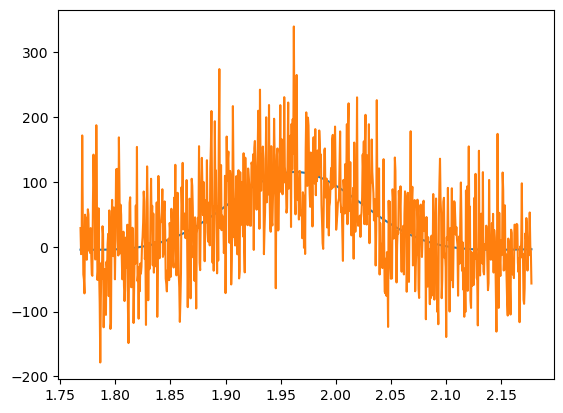

In [40]:
print(ydata[10:20])
plt.plot(xdata, fitted_curve)
plt.plot(xdata,ydata)

In [41]:
print(np.diagonal(pcov))

[9.48308080e-05 3.75056807e-04 8.89331607e-06 2.40612053e+00]


In [197]:
print(max(fitted_curve))
print(np.where(fitted_curve==max(fitted_curve)))
print(xdata[np.where(fitted_curve==max(fitted_curve))])
print(np.sum(fitted_curve))
print(np.sum(fitted_curve)*popt[0]*popt[1])
print(popt[3]/(np.sqrt(2*np.pi)*popt[0]))
print()
sig = popt[0]
gam = popt[1]
fg = 2*sig*np.sqrt(2*np.log(2))
fl = 2*sig
fv = 0.5346*-fl + np.sqrt(0.2166*fl**2+fg**2)
print(fg+popt[2])
print(fv+popt[2])
print(np.where(xdata == 2.09152))

101.14246629700477
(array([382], dtype=int64),)
[1.964032]
20014.352374261165
-160.8133132841212
34.01536457894821

2.1695839564401185
2.091678587673097
(array([631], dtype=int64),)


In [189]:
sig = popt[0]
gam = popt[1]
fg = 2*sig*np.sqrt(2*np.log(2))
fl = 2*sig
fv = 0.5346*-fl + np.sqrt(0.2166*fl**2+fg**2)
print(fv)

## plotting voigt fit ##

# plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

# plt.plot(xdata, voigt, label = 'manual fit')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$")

rebinf = 2
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

# plt.plot(xdata,ydata, label = r'rawdata')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata, rebin {rebinf}')
# plt.axhline(y = 0)
plt.axvline(x = fv/2+popt[2])
plt.axvline(x = popt[2]-fv/2)
plt.axvline(x = popt[2])


plt.title('Fits to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

0.1277801468127903


In [60]:
## more plotting ##

plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

# plt.plot(xdata, voigt, label = 'manual fit')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$")

rebinf = 4
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)

# plt.plot(xdata,ydata, label = r'rawdata')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata for voigt fit, rebin {rebinf}')

plt.axhline(y=0, ls = '--', lw = '0.5')
plt.title('Voigt fit to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

In [159]:
## more more plotting ##

plt.plot(xs_cut[1]*1e-6, ON_sums[1][0], lw = '1.0')

rebinf = 4
rawdat_rebin, xs_cut_rebin = rebin(ydata, xdata, rebinf)
ys_region_rebin, xs_region_rebin = rebin(bgsubtracted2[3:], xs_bg_reg[3:], rebinf)


# plt.plot(xs_bg_reg, bgsubtracted2, color = 'orange', lw = '1.0', label='2nd Order polynomial background subtracted')
plt.plot(xs_region_rebin, ys_region_rebin, color = 'orange', lw = '1.0', label='2nd Order polynomial background subtracted')
plt.plot(xs_cut_rebin,rawdat_rebin, label = rf'rawdata for voigt fit, rebin {rebinf}', color = 'g')

# plt.plot(xdata, voigt, label = 'manual fit')

# plt.plot(xdata,ydata, label = r'rawdata')

fitted_curve = voigt2(xdata, popt[0],popt[1],popt[2],popt[3],)
plt.plot(xdata, fitted_curve, label = rf"Voigt fit, $\sigma={round(popt[0],2)},\, \gamma={round(popt[1],2)}$", color = 'r')

plt.axhline(y=0, ls = '--', lw = '0.5')
plt.title('Voigt fit to background (On sums, 160 pulses in 1 sequence)') 
plt.xlabel("tof (ms)")
plt.ylabel("Counts (arbitrary)")
plt.xlabel("tof (ms)", fontsize = '12')
plt.ylabel("ADC", fontsize = '12')
plt.legend()
plt.show()
plt.legend()
plt.show()

ValueError: cannot reshape array of size 4809 into shape (4)

In [50]:
# print(fitted_curve)
print(max(fitted_curve))
print(min(fitted_curve))

print(sum(fitted_curve))
print(len(fitted_curve))

101.14246629700477
-16.478186809814233
20014.35237426118
800


## Other fitting methods 

try py spec kit

In [160]:
import pyspeckit

# from . import model
# import numpy as np
# from ...spectrum.moments import moments
import types
try:
    import scipy.special
    scipyOK = True
except ImportError:
    scipyOK = False

def voigt_spec(xarr, amp, xcen, sigma, gamma, normalized=True):
    if scipyOK:
        z = ((xarr-xcen) + 1j*gamma) / (sigma * np.sqrt(2))
        V = amp * np.real(scipy.special.wofz(z))
        if normalized:
            return V / (sigma*np.sqrt(2*np.pi))
        else:
            return V
    else:
        raise ImportError("Couldn't import scipy, therefore cannot do "
                          "voigt profile stuff")

xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6
ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

xarr = xdata
amp = 7*2*np.sqrt(np.pi*2)
xcen = 1.96
sigma = 0.087
gamma = -0.09

# specvoigt = pyspeckit.spectrum.models.inherited_voigtfitter.voigt(xarr, amp, xcen, sigma, gamma, normalized=False)
specvoigt = voigt_spec(xarr, amp, xcen, sigma, gamma, normalized=False)

print(max(specvoigt))
print(amp)
print(sum(specvoigt))
print(sum(specvoigt)/(sigma*np.sqrt(2*np.pi)))
trysum = (specvoigt)/(sigma*np.sqrt(2*np.pi))
print(sum(trysum))

plt.plot(xdata, specvoigt)
plt.plot(xdata,ydata)

popt_spec, pcov_spec = curve_fit(voigt_spec, xdata, ydata)
print(popt)
print(pcov)

fitted_curve_spec = voigt_spec(xdata, popt[0],popt[1],popt[2],popt[3],)

print(max(fitted_curve))
print((popt[3])*np.sqrt(2*np.pi))
print((popt[3])/(np.sqrt(2*np.pi)*popt[0]))
print((popt[3])/(popt[0]))
print(sum(fitted_curve)*(popt[0]*np.sqrt(2*np.pi)))

print(101.14246/(2*np.pi*2))

101.81577111002956
35.092795844834
20458.752461586395
93814.49840452531
93814.49840452542
[ 0.06832468 -0.02673279  1.96326366 14.02661661]
[[ 9.48308080e-05 -1.81254284e-04 -8.45848374e-08 -1.18037678e-02]
 [-1.81254284e-04  3.75056807e-04  1.74621258e-07  2.68464332e-02]
 [-8.45848374e-08  1.74621258e-07  8.89331607e-06  1.22199150e-05]
 [-1.18037678e-02  2.68464332e-02  1.22199150e-05  2.40612053e+00]]
115.32742747196691
35.15951379275074
81.90027718795059
205.29355049943322
5144.737175679104
8.04866123273715


Covariance of the parameters could not be estimated


try astropy ...

In [53]:
from astropy.modeling.models import Voigt1D

# popt, pcov = curve_fit(Voigt1D, xdata, ydata)

x = np.arange(1.7, 2.2, 0.01)
v1 = Voigt1D(x_0=1.98, amplitude_L=100, fwhm_L=0.08, fwhm_G=0.01)
plt.plot(x, v1(x))

# v1 = Voigt1D(x_0=5, amplitude_L=10, fwhm_L=0.5, fwhm_G=0.9)
# fitted_curve = Voigt1D(xdata, popt[0],popt[1],popt[2],)
xdata = xs_cut[0][res_reg[0]:res_reg[1]]*1e-6

ydata = ON_bgsub[1][0][bg_reg1[1]-bg_reg1[0]:bg_reg2[0]-bg_reg1[0]]

# voigt = voigt_profile(xdata-shift, sigma, gamma)*mult
# print(voigt)
# def voigt2(x, sig, gam, xshift, amp):
#     fit = voigt_profile(x-xshift, sig, gam)*amp
#     return fit

# plt.plot(xdata, voigt)
plt.plot(xdata,ydata)
plt.show()


from astropy.modeling import models, fitting

x = xdata
y = ydata

g_init = Voigt1D(x_0=1.98, amplitude_L=100, fwhm_L=0.08, fwhm_G=0.01)
# fit_g = fitting.TRFLSQFitter(calc_uncertainties=False)
# g = fit_g(g_init, x, y)

testmax = (max(ydata))
# g_init = Voigt1D(x_0=2, amplitude_L=1000, fwhm_L=0.636, fwhm_G=0.693)
fit_g = fitting.TRFLSQFitter(calc_uncertainties=False)
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, g(x), label='voigt astropy')
# plt.xlabel('Position')
# plt.ylabel('Flux')
plt.legend(loc=2)
print(fit_g)
print(g)
print(max(g(x)))
print(np.std(g(x)))
# fit_g.fit_info

fit_g(g_init, x, y)



## saving to hdf5 ##

In [28]:
import h5py
import gzip

In [25]:
b = np.char.zfill(str(chan_enab[11]), 2)
print(b)
print(type(b))
ch_list = str(chan_enab)

11
<class 'numpy.ndarray'>


In [30]:
## straight numpy save
# Save the NumPy array to an HDF5 file
with h5py.File('testtesttest_ysh5'+'.h5', 'w') as hdf5_file:
    hdf5_file.create_dataset('dataset', data=ys_cut)

# # Read the NumPy array from the HDF5 file
# with h5py.File(hdf5_file_path, 'r') as hdf5_file:
#     loaded_array = hdf5_file['dataset'][:]

In [30]:
# try compression
start = time.time()

testch = 0

with h5py.File('test_addingmultipleys'+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[testch]), data=ys_cut[testch])
#     hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[0], compression="gzip")
    hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[testch])
    
# i = 2
# with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[i]), data=ys_cut[i])

for i in range(1,len(ys_cut)):
    with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#         hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i], compression="gzip")
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i])
        
# f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
# np.save(file=f, arr=ys_cut)
# f.close()
        
end = time.time()
print('saving hdf5: ' + str(end-start))

saving hdf5: 8.730424404144287


In [29]:
# Save the NumPy array to an HDF5 file
start = time.time()

testch = 0

with h5py.File('test_addingmultipleys'+'.h5', 'w') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[testch]), data=ys_cut[testch])
    hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[0]), 2)), data=ys_cut[testch])

    
# i = 2
# with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
#     hdf5_file.create_dataset('ch '+str(chan_enab[i]), data=ys_cut[i])

for i in range(1,len(ys_cut)):
    with h5py.File('test_addingmultipleys'+'.h5', 'a') as hdf5_file:
        hdf5_file.create_dataset('ch '+str(np.char.zfill(str(chan_enab[i]), 2)), data=ys_cut[i])
        
end = time.time()
print('saving hdf5: ' + str(end-start))    

saving hdf5: 8.799411296844482


In [33]:
## try compressed np array
start = time.time()

f = gzip.GzipFile("testcompressednparr.npy.gz", "w")
np.save(file=f, arr=ys_cut)
f.close()

end = time.time()
print('saving hdf5: ' + str(end-start))   

saving hdf5: 236.83496618270874


In [28]:
testdf = pd.DataFrame(ys_cut[0])
# print(testdf)
testdf.to_hdf('testing1chdf.h5', key='df', mode='w')

In [12]:
start = time.time()

np.save('testing_cutys_npoutput', ys_cut)

end = time.time()
print('aligning and cutting time: ' + str(end-start))   

aligning and cutting time: 10.02809476852417


## older stuff ##

In [18]:
# OLD: changed to just saving ON and OFF pulses. Keeping if needed in later use. 09.30.2024

#  add up pulses for their respective state, in each 8 step sequence ##
#  turning into a by-channel function 06.13.24 ##

start = time.time()
sequence = np.asarray(sequence, dtype = object)

# added_pulses = np.zeros((len(ys_cut), len(sequence[0]), 8, len(ys_cut[0][0])), dtype=np.float64) ## 13 sequences, 8 stages each works?
# i channels, 13 sequences each, 8 states each sequence, 8992 num points ##

ON_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
ONOFF_minus_sums = np.zeros((len(ys_cut), len(sequence[0]),2, len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
ONOFF_plus_sums = np.zeros((len(ys_cut), len(sequence[0]),2, len(ys_cut[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF

# ON_OFF_sums = np.zeros((len(ys_cut), len(sequence[0]), 2, len(ys_cut[0][0])), dtype=np.float64) ## 13 sequences, 2 for ON or OFF for each sequence
# ON_sums = np.zeros((len(ys_basesub), len(sequence[0]), len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
# OFF_sums = np.zeros((len(ys_basesub), len(sequence[0]), len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
# ON_minus_sums = np.zeros((len(ys_basesub), len(sequence[0]),2, len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for ON
# ON_plus_sums = np.zeros((len(ys_basesub), len(sequence[0]),2, len(ys_basesub[0][0])), dtype=np.float64) ## 13 channels, 13 sequences, added pulses for OFF
# ON_minus/plus_sums have their 2 for associated OFF states in the second array

# @njit
def add_pulse(ys, SFarr):
#     tempadded_p = np.zeros((len(SFarr[0]), 8, len(ys[0])), dtype=np.float64)
    temp_ON = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_OFF = np.zeros((len(SFarr[0]), len(ys[0])), dtype=np.float64)
    temp_ONOFF_min = np.zeros((len(SFarr[0]),2, len(ys[0])), dtype=np.float64)
    temp_ONOFF_plu = np.zeros((len(SFarr[0]),2, len(ys[0])), dtype=np.float64)
    for seq in range(0, len(SFarr[0])): ## for every sequence
    #         print('seq:' +str(SFarr[0][seq]))
#         print('seq:' +str(seq))
        for state in range(0, len(SFarr[1][0])): ## for every state in the sequence
    #         print("states loop " + str(range(0, len(SFarr[1][0]))[0]) + ' - ' +  str(range(0, len(SFarr[1][0]))[-1]))
            s = SFarr[1][seq][state] ## try this to condense code. Basically, the state currently at
            if s==0 or s==3 or s==5 or s==6: ## these are ON states
#                 print('ON "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_ON[seq] = np.add(temp_ON[seq],ys[p]) ## start with zeros, add to each iteratively
#                     print(p)
                #         below is for splitting up into ON(-) and ON(+) and their associated OFF states (1 state forward for -, 1 state backward for +)
                if s==0 or s==6: ## these or ON(-) states
                    OFF_i = np.where(np.asarray(SFarr[1][0])==s+1)[0][0] ## find where in sequence state = s(ON-)+1    
    #                 print('ON(-) "s" ' +str(s) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
                    for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_min[seq][0] = np.add(temp_ONOFF_min[seq][0],ys[p]) ## start with zeros, add to each iteratively
    #                 print('OFF state ' + str(SFarr[1][seq][OFF_i]))
                    for p in range((SFarr[2][seq][OFF_i][0]),(SFarr[2][seq][OFF_i][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_min[seq][1] = np.add(temp_ONOFF_min[seq][1],ys[p]) ## start with zeros, add to each iteratively
                if s==3 or s==5: ## these or ON(+) states
                    OFF_i = np.where(np.asarray(SFarr[1][0])==s-1)[0][0] ## find where in sequence state = s(ON+)-1    
    #                 print('ON(+) "s" ' +str(s) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
                    for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_plu[seq][0] = np.add(temp_ONOFF_plu[seq][0],ys[p]) ## start with zeros, add to each iteratively
    #                 print('OFF state ' + str(SFarr[1][seq][OFF_i]))
                    for p in range((SFarr[2][seq][OFF_i][0]),(SFarr[2][seq][OFF_i][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                        temp_ONOFF_plu[seq][1] = np.add(temp_ONOFF_plu[seq][1],ys[p]) ## start with zeros, add to each iteratively
            if s==1 or s==2 or s==4 or s==7: ## these are OFF states
#                 print('OFF "s" state '+str(s))
#                 print('"state" ' +str(state) + ' from ' + str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))))
#                 print('sums from '+str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[0]) +
#                 ' - ' +str(range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1]))[-1]) + '\n')
                for p in range((SFarr[2][seq][state][0]),(SFarr[2][seq][state][1])): ##From 20-60 for example. SFarr[2] is the array of start to end pulses to sum
                    temp_OFF[seq] = np.add(temp_OFF[seq],ys[p]) ## start with zeros, add to each iteratively
#                     print(p)
    return temp_ON, temp_OFF, temp_ONOFF_min, temp_ONOFF_plu

for i in range(len(ys_cut)):
#     print('#################### channel: ' + str(i) + ' ##########################')
    ON_sums[i], OFF_sums[i], ONOFF_minus_sums[i], ONOFF_plus_sums[i] = add_pulse(ys_cut[i], sequence)
    
# for i in range(len(ys_basesub)-12):
#     print('#################### channel: ' + str(i) + ' ##########################')
#     ON_sums[i], OFF_sums[i], ON_minus_sums[i], ON_plus_sums[i] = add_pulse(ys_basesub[i], sequence)

end = time.time()
print('summing pulses into their states time: ' + str(end-start))  

summing pulses into their states time: 0.7072417736053467
